# Model Training
## Group SHINOBI: HONG-KOH-NOUV

This python notebook contents the results of training the model in different ways before submitting to ramp.

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

# Model Building
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier, VotingClassifier

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.calibration import CalibratedClassifierCV

# Evaluation
from sklearn.metrics import balanced_accuracy_score
from problem import BalancedAccuracy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight

## Data Preprocessing

- The EDA revealed large variability in total gene expression across cells, indicating differences in sequencing depth; therefore, normalization is applied to make cells comparable.
- Gene expression distributions were highly right-skewed with extreme values, motivating the use of a log transformation to stabilize variance and reduce the influence of outliers.
- Gene variance analysis showed that only a small subset of genes captures most of the variability in the data, justifying the selection of highly variable genes to reduce noise and dimensionality.
- Restricting the feature space to the most variable genes retains informative biological signals while discarding genes with little discriminative power.
- The presence of correlated genes and high-dimensional feature space motivates feature standardization to ensure comparable scaling before downstream analyses.
- The rapid accumulation of explained variance in the first principal components and strong gene redundancy justify the use of PCA to reduce dimensionality while preserving the main structure of the data.

### Preprocessing Pipeline

Preprocessing pipelines are evaluated progressively, starting from raw data and gradually incorporating normalization, variance stabilization, feature selection, scaling, and dimensionality reduction to assess their impact on model performance.

- Pipeline 1: Raw baseline
    - No preprocessing.
    - Used as a reference to measure the benefit of all transformations.

- Pipeline 2: Normalization only
    - Cells are normalized by their total expression to correct for sequencing depth differences.

- Pipeline 3: Normalization + log transform
    - Log transformation is added to reduce skewness and stabilize variance after normalization.

- Pipeline 4: Normalization + log transform + HVG selection
    - Feature space is reduced by keeping only highly variable genes, removing uninformative genes.

- Pipeline 5: Normalization + log transform + HVG selection + scaling
    - Features are standardized to ensure comparable scales, which is important for linear models and PCA.

- Pipeline 6: Normalization + log transform + HVG selection + scaling + PCA
    - Dimensionality is further reduced using PCA to remove redundancy and retain the main sources of variation.

In [2]:
from problem import get_train_data, get_test_data
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

In [3]:
def preprocess_normalize_sum(X_sparse):
    X = X_sparse.toarray().astype(np.float32)
    row_sum = X.sum(axis=1, keepdims=True)
    row_sum[row_sum == 0] = 1.0
    return X / row_sum

def preprocess_log1p(X):
    return np.log1p(X)

def fit_hvg_variance(X, top_k=2000):
    gene_var = X.var(axis=0)
    idx = np.argsort(gene_var)[-top_k:]
    return idx

def transform_gene_filter(X, gene_idx):
    return X[:, gene_idx]

def fit_standard_scaler(X):
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    std[std == 0] = 1.0
    return mean, std

def transform_standard_scaler(X, mean, std):
    return (X - mean) / std

def fit_pca(X, n_components=50):
    pca = PCA(n_components=n_components, random_state=0)
    pca.fit(X)
    return pca

def transform_pca(X, pca):
    return pca.transform(X)

## Modeling

### Logistic Regression

Pipeline 0 (RAW) - Train balanced accuracy: 1.0
Pipeline 0 (RAW) - Test  balanced accuracy: 0.7766


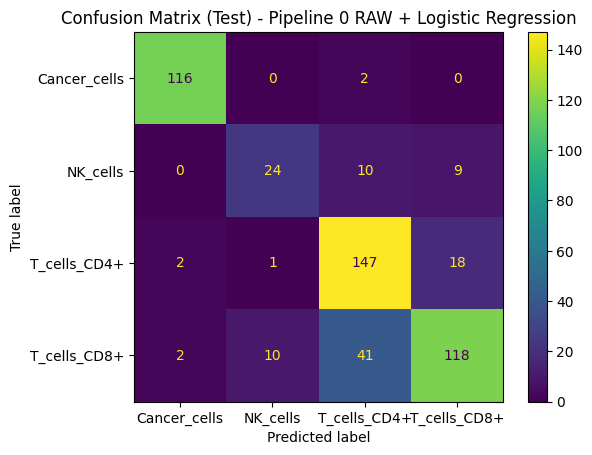

In [4]:
# =========================
# PIPELINE 0: RAW FEATURES
# =========================
X_train_0 = X_train.toarray().astype(np.float32)
X_test_0  = X_test.toarray().astype(np.float32)

pipe_0_logr = Pipeline(
    [
        (
            "Logistic Regression",
            LogisticRegression(
                solver="lbfgs",
                penalty=None,
                max_iter=2000,
                class_weight="balanced",
                random_state=42,
            ),
        ),
    ]
)

# Fit
pipe_0_logr.fit(X_train_0, y_train)

# Predict
y_train_pred_0 = pipe_0_logr.predict(X_train_0)
y_test_pred_0  = pipe_0_logr.predict(X_test_0)

# Score (balanced accuracy)
print("Pipeline 0 (RAW) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred_0), 4))
print("Pipeline 0 (RAW) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred_0), 4))

# Confusion matrix (test)
cm_0 = confusion_matrix(y_test, y_test_pred_0, labels=pipe_0_logr.classes_)
disp_0 = ConfusionMatrixDisplay(confusion_matrix=cm_0, display_labels=pipe_0_logr.classes_)
disp_0.plot()
plt.title("Confusion Matrix (Test) - Pipeline 0 RAW + Logistic Regression")
plt.show()


Train balanced accuracy: 1.0
Test  balanced accuracy: 0.7977


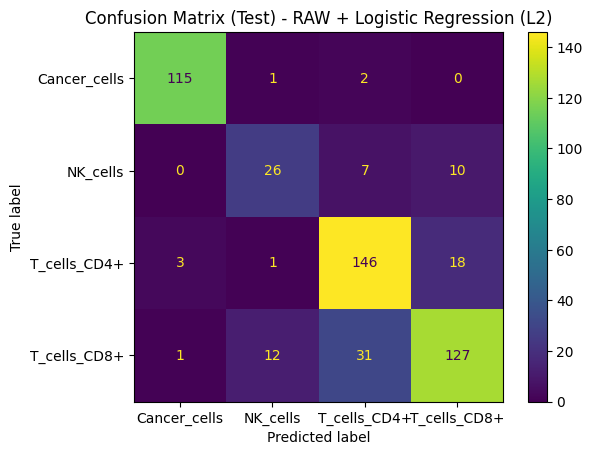

In [5]:
pipe_0_logr_p = Pipeline(
    [
        (
            "Logistic Regression",
            LogisticRegression(
                solver="lbfgs",
                penalty="l2",
                C=0.05,
                max_iter=2000,
                class_weight="balanced",
                random_state=42,
            ),
        ),
    ]
)

pipe_0_logr_p.fit(X_train_0, y_train)

y_train_pred_0 = pipe_0_logr_p.predict(X_train_0)
y_test_pred_0  = pipe_0_logr_p.predict(X_test_0)

print("Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred_0), 4))
print("Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred_0), 4))

cm_0 = confusion_matrix(y_test, y_test_pred_0, labels=pipe_0_logr_p.classes_)
disp_0 = ConfusionMatrixDisplay(confusion_matrix=cm_0, display_labels=pipe_0_logr_p.classes_)
disp_0.plot()
plt.title("Confusion Matrix (Test) - RAW + Logistic Regression (L2)")
plt.show()

Pipeline 1 (NORM) - Train balanced accuracy: 0.9768
Pipeline 1 (NORM) - Test  balanced accuracy: 0.7926


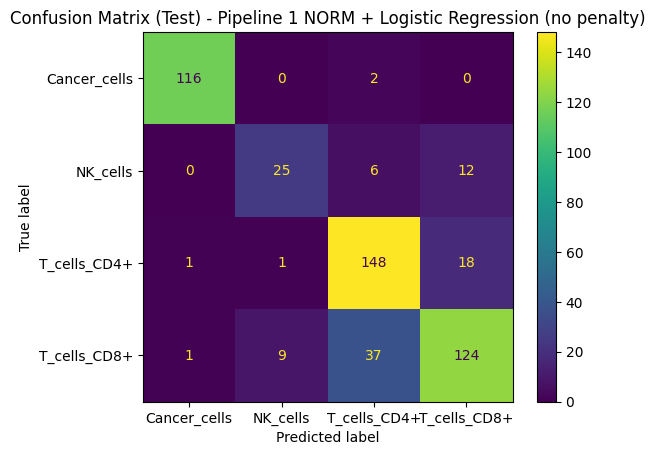

In [6]:
# =========================
# PIPELINE 1: NORMALIZED FEATURES (row-sum normalization)
# =========================

# Preprocess: normalize each row by its sum
X_train_1 = preprocess_normalize_sum(X_train)   # uses your function
X_test_1  = preprocess_normalize_sum(X_test)

# -------------------------
# Logistic Regression (no penalty)
# -------------------------
pipe_1_logr = Pipeline(
    [
        (
            "Logistic Regression",
            LogisticRegression(
                solver="lbfgs",
                penalty=None,
                max_iter=2000,
                class_weight="balanced",
                random_state=42,
            ),
        ),
    ]
)

pipe_1_logr.fit(X_train_1, y_train)

y_train_pred_1 = pipe_1_logr.predict(X_train_1)
y_test_pred_1  = pipe_1_logr.predict(X_test_1)

print("Pipeline 1 (NORM) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred_1), 4))
print("Pipeline 1 (NORM) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred_1), 4))

cm_1 = confusion_matrix(y_test, y_test_pred_1, labels=pipe_1_logr.classes_)
disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=pipe_1_logr.classes_)
disp_1.plot()
plt.title("Confusion Matrix (Test) - Pipeline 1 NORM + Logistic Regression (no penalty)")
plt.show()

Train balanced accuracy: 0.6967
Test  balanced accuracy: 0.6654


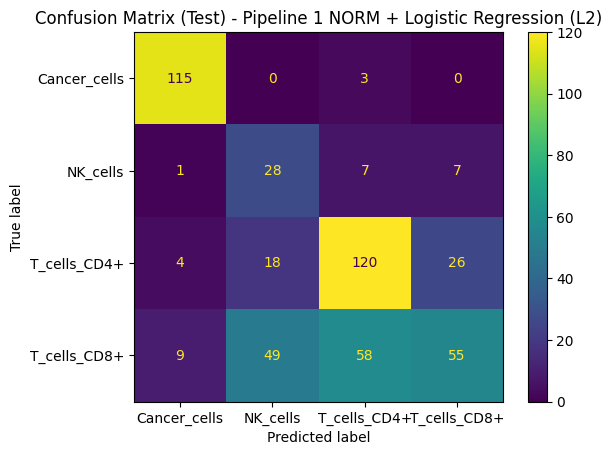

In [7]:
# -------------------------
# Logistic Regression (L2 penalty)
# -------------------------
pipe_1_logr_p = Pipeline(
    [
        (
            "Logistic Regression",
            LogisticRegression(
                solver="lbfgs",
                penalty="l2",
                C=10,
                max_iter=1000,
                class_weight="balanced",
                random_state=42,
            ),
        ),
    ]
)

pipe_1_logr_p.fit(X_train_1, y_train)

y_train_pred_1 = pipe_1_logr_p.predict(X_train_1)
y_test_pred_1  = pipe_1_logr_p.predict(X_test_1)

print("Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred_1), 4))
print("Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred_1), 4))

cm_1 = confusion_matrix(y_test, y_test_pred_1, labels=pipe_1_logr_p.classes_)
disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=pipe_1_logr_p.classes_)
disp_1.plot()
plt.title("Confusion Matrix (Test) - Pipeline 1 NORM + Logistic Regression (L2)")
plt.show()


Pipeline 2 (NORM+LOG) - Train balanced accuracy: 1.0
Pipeline 2 (NORM+LOG) - Test  balanced accuracy: 0.7919


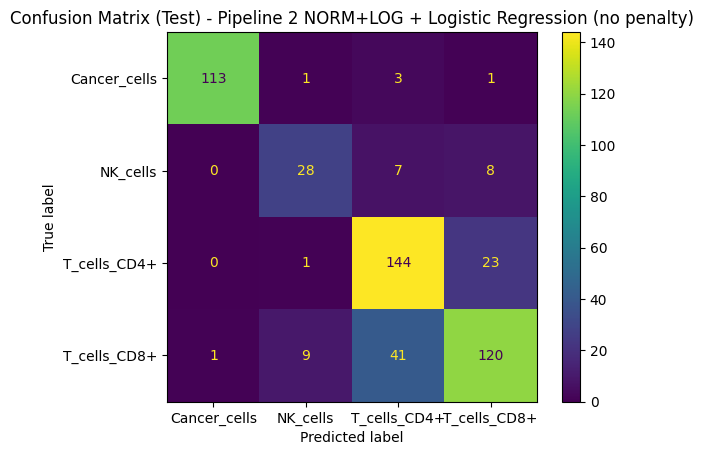

In [8]:
# =========================
# PIPELINE 2: NORMALIZE + LOG1P FEATURES
# =========================

# Preprocess: normalize each row by its sum + log1p
X_train_2 = preprocess_log1p(preprocess_normalize_sum(X_train))  # uses your functions
X_test_2  = preprocess_log1p(preprocess_normalize_sum(X_test))

# -------------------------
# Logistic Regression (no penalty)
# -------------------------
pipe_2_logr = Pipeline(
    [
        (
            "Logistic Regression",
            LogisticRegression(
                solver="lbfgs",
                penalty=None,
                max_iter=2000,
                random_state=42,
            ),
        ),
    ]
)

pipe_2_logr.fit(X_train_2, y_train)

y_train_pred_2 = pipe_2_logr.predict(X_train_2)
y_test_pred_2  = pipe_2_logr.predict(X_test_2)

print("Pipeline 2 (NORM+LOG) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred_2), 4))
print("Pipeline 2 (NORM+LOG) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred_2), 4))

cm_2 = confusion_matrix(y_test, y_test_pred_2, labels=pipe_2_logr.classes_)
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=pipe_2_logr.classes_)
disp_2.plot()
plt.title("Confusion Matrix (Test) - Pipeline 2 NORM+LOG + Logistic Regression (no penalty)")
plt.show()



Train balanced accuracy: 0.5694
Test  balanced accuracy: 0.558


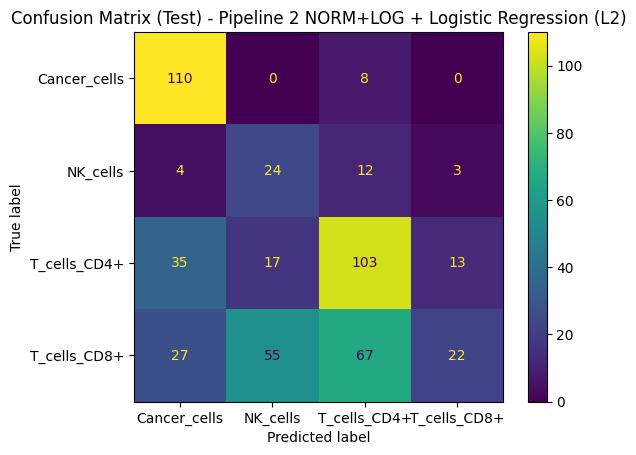

In [9]:

# -------------------------
# Logistic Regression (L2 penalty)
# -------------------------
pipe_2_logr_p = Pipeline(
    [
        (
            "Logistic Regression",
            LogisticRegression(
                solver="lbfgs",
                penalty="l2",
                C=0.05,
                max_iter=2000,
                class_weight="balanced",
                random_state=42,
            ),
        ),
    ]
)

pipe_2_logr_p.fit(X_train_2, y_train)

y_train_pred_2 = pipe_2_logr_p.predict(X_train_2)
y_test_pred_2  = pipe_2_logr_p.predict(X_test_2)

print("Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred_2), 4))
print("Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred_2), 4))

cm_2 = confusion_matrix(y_test, y_test_pred_2, labels=pipe_2_logr_p.classes_)
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=pipe_2_logr_p.classes_)
disp_2.plot()
plt.title("Confusion Matrix (Test) - Pipeline 2 NORM+LOG + Logistic Regression (L2)")
plt.show()


Pipeline 3 (NORM+LOG+HVG) - Train balanced accuracy: 0.9798
Pipeline 3 (NORM+LOG+HVG) - Test  balanced accuracy: 0.7722


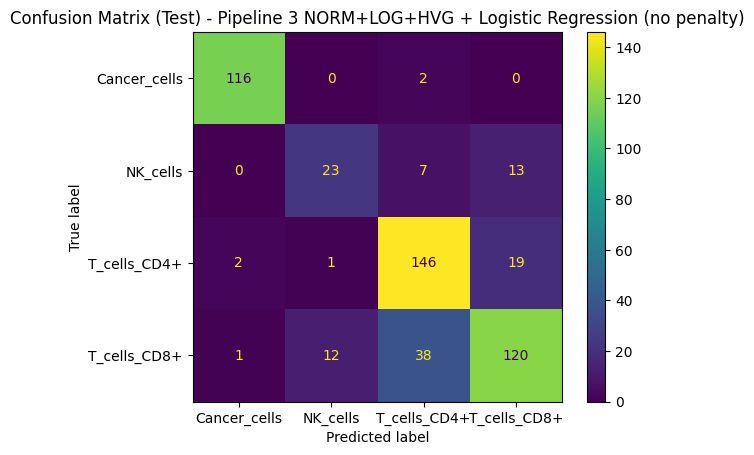

In [10]:
# -------------------------------------------------
# Step 1: base preprocessing (normalize + log1p)
# -------------------------------------------------
X_train_base = preprocess_log1p(preprocess_normalize_sum(X_train))
X_test_base  = preprocess_log1p(preprocess_normalize_sum(X_test))

# -------------------------------------------------
# Step 2: fit HVG on TRAIN ONLY (avoid leakage)
# -------------------------------------------------
top_k = 2000
gene_idx = fit_hvg_variance(X_train_base, top_k=top_k)

# Transform train/test using the same HVG index
X_train_3 = transform_gene_filter(X_train_base, gene_idx)
X_test_3  = transform_gene_filter(X_test_base, gene_idx)

# -------------------------
# Logistic Regression (no penalty)
# -------------------------
pipe_3_logr = Pipeline(
    [
        (
            "Logistic Regression",
            LogisticRegression(
                solver="lbfgs",
                penalty=None,
                max_iter=2000,
                class_weight="balanced",
                random_state=42,
            ),
        ),
    ]
)

pipe_3_logr.fit(X_train_3, y_train)

y_train_pred_3 = pipe_3_logr.predict(X_train_3)
y_test_pred_3  = pipe_3_logr.predict(X_test_3)

print("Pipeline 3 (NORM+LOG+HVG) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred_3), 4))
print("Pipeline 3 (NORM+LOG+HVG) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred_3), 4))

cm_3 = confusion_matrix(y_test, y_test_pred_3, labels=pipe_3_logr.classes_)
disp_3 = ConfusionMatrixDisplay(confusion_matrix=cm_3, display_labels=pipe_3_logr.classes_)
disp_3.plot()
plt.title("Confusion Matrix (Test) - Pipeline 3 NORM+LOG+HVG + Logistic Regression (no penalty)")
plt.show()



Train balanced accuracy: 0.5676
Test  balanced accuracy: 0.5566


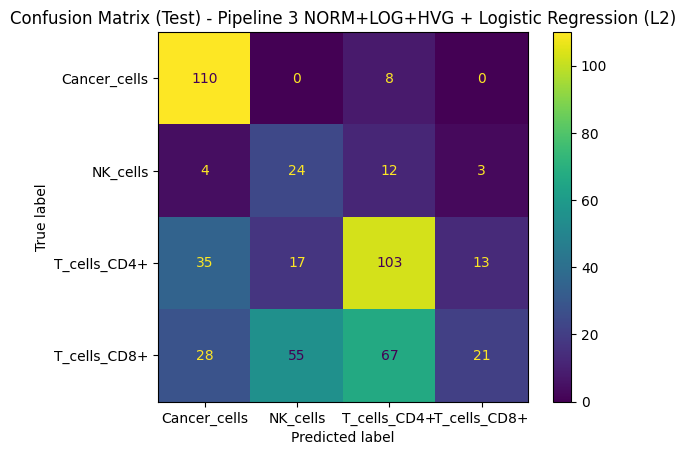

In [12]:

# -------------------------
# Logistic Regression (L2 penalty)
# -------------------------
pipe_3_logr_p = Pipeline(
    [
        (
            "Logistic Regression",
            LogisticRegression(
                solver="lbfgs",
                penalty="l2",
                C=0.05,
                max_iter=1000,
                class_weight="balanced",
                random_state=42,
            ),
        ),
    ]
)

pipe_3_logr_p.fit(X_train_3, y_train)

y_train_pred_3 = pipe_3_logr_p.predict(X_train_3)
y_test_pred_3  = pipe_3_logr_p.predict(X_test_3)

print("Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred_3), 4))
print("Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred_3), 4))

cm_3 = confusion_matrix(y_test, y_test_pred_3, labels=pipe_3_logr_p.classes_)
disp_3 = ConfusionMatrixDisplay(confusion_matrix=cm_3, display_labels=pipe_3_logr_p.classes_)
disp_3.plot()
plt.title("Confusion Matrix (Test) - Pipeline 3 NORM+LOG+HVG + Logistic Regression (L2)")
plt.show()

Pipeline 4 (NORM+LOG+HVG+SCALE) - Train balanced accuracy: 1.0
Pipeline 4 (NORM+LOG+HVG+SCALE) - Test  balanced accuracy: 0.8491


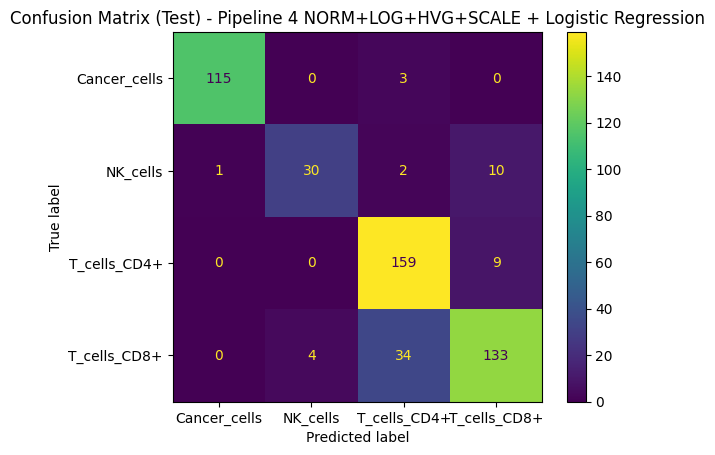

In [12]:
# =========================
# PIPELINE 4: NORMALIZE + LOG1P + HVG + SCALING
# Logistic Regression (no penalty)
# =========================

# -------------------------------------------------
# Step 1: normalize + log1p
# -------------------------------------------------
X_train_base = preprocess_log1p(preprocess_normalize_sum(X_train))
X_test_base  = preprocess_log1p(preprocess_normalize_sum(X_test))

# -------------------------------------------------
# Step 2: HVG fit on TRAIN ONLY
# -------------------------------------------------
top_k = 3000
gene_idx = fit_hvg_variance(X_train_base, top_k=top_k)

X_train_hvg = transform_gene_filter(X_train_base, gene_idx)
X_test_hvg  = transform_gene_filter(X_test_base, gene_idx)

# -------------------------------------------------
# Step 3: scaling fit on TRAIN ONLY
# -------------------------------------------------
mean, std = fit_standard_scaler(X_train_hvg)
X_train_4 = transform_standard_scaler(X_train_hvg, mean, std)
X_test_4  = transform_standard_scaler(X_test_hvg, mean, std)

# -------------------------------------------------
# Model: Logistic Regression (no penalty)
# -------------------------------------------------
pipe_4_logr = Pipeline(
    [
        (
            "Logistic Regression",
            LogisticRegression(
                solver="lbfgs",
                penalty=None,
                max_iter=2000,
                random_state=42,
            ),
        ),
    ]
)

pipe_4_logr.fit(X_train_4, y_train)

y_train_pred_4 = pipe_4_logr.predict(X_train_4)
y_test_pred_4  = pipe_4_logr.predict(X_test_4)

print("Pipeline 4 (NORM+LOG+HVG+SCALE) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred_4), 4))
print("Pipeline 4 (NORM+LOG+HVG+SCALE) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred_4), 4))

cm_4 = confusion_matrix(y_test, y_test_pred_4, labels=pipe_4_logr.classes_)
disp_4 = ConfusionMatrixDisplay(confusion_matrix=cm_4, display_labels=pipe_4_logr.classes_)
disp_4.plot()
plt.title("Confusion Matrix (Test) - Pipeline 4 NORM+LOG+HVG+SCALE + Logistic Regression")
plt.show()


Pipeline 4 (NORM+LOG+HVG+SCALE) - Train balanced accuracy: 1.0
Pipeline 4 (NORM+LOG+HVG+SCALE) - Test  balanced accuracy: 0.8171


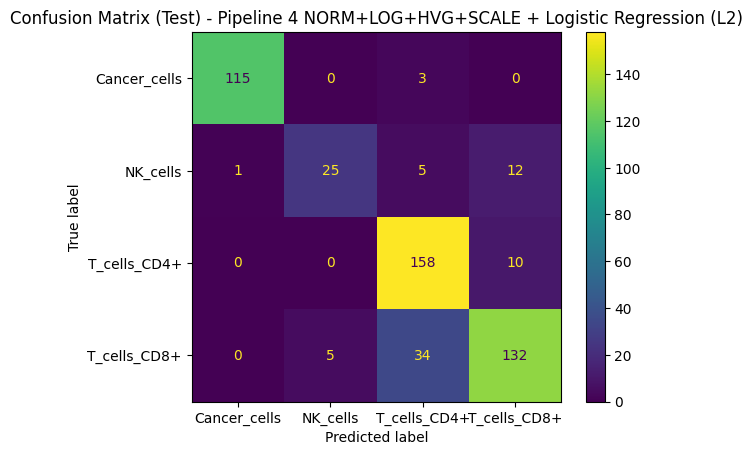

In [13]:
# -------------------------------------------------
# Model: Logistic Regression (L2 penalty)
# -------------------------------------------------
pipe_4_logr_l2 = Pipeline(
    [
        (
            "Logistic Regression",
            LogisticRegression(
                solver="lbfgs",
                penalty="l2",
                C=0.05,
                max_iter=2000,
                class_weight="balanced",
                random_state=42,
            ),
        ),
    ]
)

pipe_4_logr_l2.fit(X_train_4, y_train)

y_train_pred_4 = pipe_4_logr_l2.predict(X_train_4)
y_test_pred_4  = pipe_4_logr_l2.predict(X_test_4)

print("Pipeline 4 (NORM+LOG+HVG+SCALE) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred_4), 4))
print("Pipeline 4 (NORM+LOG+HVG+SCALE) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred_4), 4))

cm_4 = confusion_matrix(y_test, y_test_pred_4, labels=pipe_4_logr_l2.classes_)
disp_4 = ConfusionMatrixDisplay(confusion_matrix=cm_4, display_labels=pipe_4_logr_l2.classes_)
disp_4.plot()
plt.title("Confusion Matrix (Test) - Pipeline 4 NORM+LOG+HVG+SCALE + Logistic Regression (L2)")
plt.show()


Pipeline 5 (NORM+LOG+HVG+SCALE+PCA) - Train balanced accuracy: 1.0
Pipeline 5 (NORM+LOG+HVG+SCALE+PCA) - Test  balanced accuracy: 0.8338


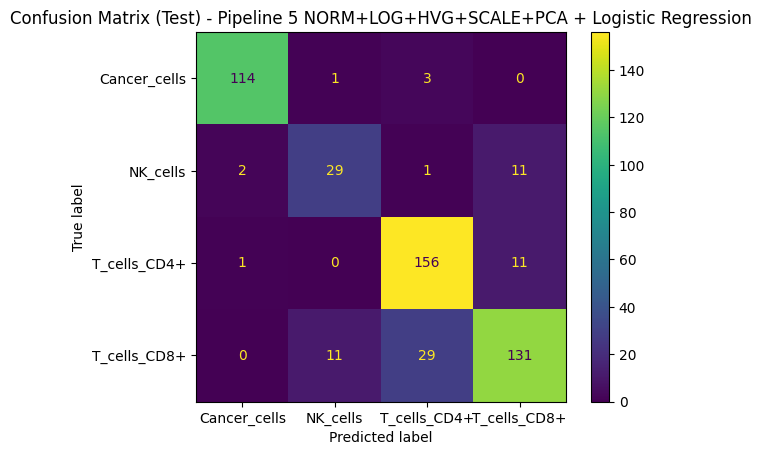

In [14]:
# =========================
# PIPELINE 5: NORMALIZE + LOG1P + HVG + SCALING + PCA
# Logistic Regression (no penalty)
# =========================

# -------------------------------------------------
# Step 1: normalize + log1p
# -------------------------------------------------
X_train_base = preprocess_log1p(preprocess_normalize_sum(X_train))
X_test_base  = preprocess_log1p(preprocess_normalize_sum(X_test))

# -------------------------------------------------
# Step 2: HVG fit on TRAIN ONLY
# -------------------------------------------------
top_k = 3000
gene_idx = fit_hvg_variance(X_train_base, top_k=top_k)

X_train_hvg = transform_gene_filter(X_train_base, gene_idx)
X_test_hvg  = transform_gene_filter(X_test_base, gene_idx)

# -------------------------------------------------
# Step 3: scaling fit on TRAIN ONLY
# -------------------------------------------------
mean, std = fit_standard_scaler(X_train_hvg)
X_train_scaled = transform_standard_scaler(X_train_hvg, mean, std)
X_test_scaled  = transform_standard_scaler(X_test_hvg, mean, std)

# -------------------------------------------------
# Step 4: PCA fit on TRAIN ONLY
# -------------------------------------------------
n_components = 500
pca = fit_pca(X_train_scaled, n_components=n_components)

X_train_5 = transform_pca(X_train_scaled, pca)
X_test_5  = transform_pca(X_test_scaled, pca)

# -------------------------------------------------
# Model: Logistic Regression (no penalty)
# -------------------------------------------------
pipe_5_logr = Pipeline(
    [
        (
            "Logistic Regression",
            LogisticRegression(
                solver="lbfgs",
                penalty=None,
                max_iter=2000,
                class_weight="balanced",
                random_state=42,
            ),
        ),
    ]
)

pipe_5_logr.fit(X_train_5, y_train)

y_train_pred_5 = pipe_5_logr.predict(X_train_5)
y_test_pred_5  = pipe_5_logr.predict(X_test_5)

print("Pipeline 5 (NORM+LOG+HVG+SCALE+PCA) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred_5), 4))
print("Pipeline 5 (NORM+LOG+HVG+SCALE+PCA) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred_5), 4))

cm_5 = confusion_matrix(y_test, y_test_pred_5, labels=pipe_5_logr.classes_)
disp_5 = ConfusionMatrixDisplay(confusion_matrix=cm_5, display_labels=pipe_5_logr.classes_)
disp_5.plot()
plt.title("Confusion Matrix (Test) - Pipeline 5 NORM+LOG+HVG+SCALE+PCA + Logistic Regression")
plt.show()


### Linear SVM

Linear SVM - P0 RAW - Train balanced accuracy: 1.0
Linear SVM - P0 RAW - Test  balanced accuracy: 0.744


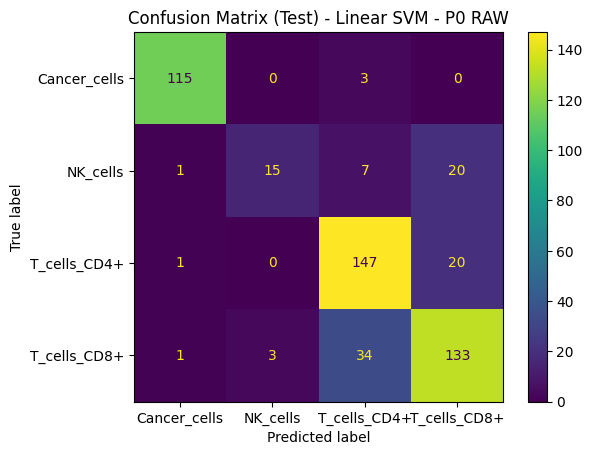

In [15]:
# LinearSVC does NOT have predict_proba, so we calibrate it to get probabilities
svm_0 = LinearSVC(
    C=0.1,
    class_weight="balanced",
    random_state=42,
    max_iter=10000,
)

pipe_0_svm = Pipeline(
    [
        ("LinearSVC", CalibratedClassifierCV(svm_0, method="sigmoid", cv=5)),
    ]
)

pipe_0_svm.fit(X_train_0, y_train)

y_train_pred_0 = pipe_0_svm.predict(X_train_0)
y_test_pred_0  = pipe_0_svm.predict(X_test_0)

print("Linear SVM - P0 RAW - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred_0), 4))
print("Linear SVM - P0 RAW - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred_0), 4))

cm_0 = confusion_matrix(y_test, y_test_pred_0, labels=pipe_0_svm.classes_)
disp_0 = ConfusionMatrixDisplay(confusion_matrix=cm_0, display_labels=pipe_0_svm.classes_)
disp_0.plot()
plt.title("Confusion Matrix (Test) - Linear SVM - P0 RAW")
plt.show()

Linear SVM - P4 - Train balanced accuracy: 0.9353
Linear SVM - P4 - Test  balanced accuracy: 0.6877


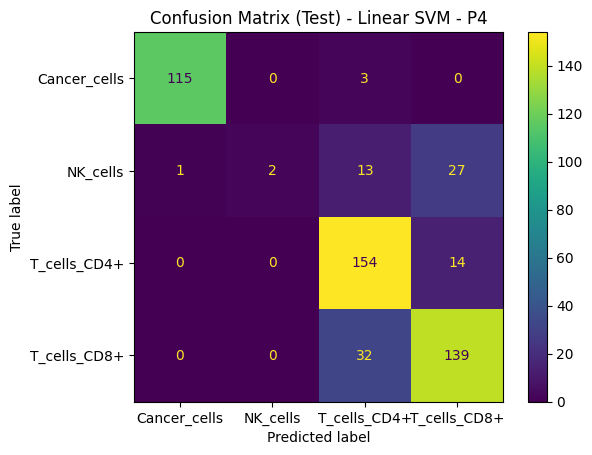

In [16]:
# Calibrated Linear SVM
svm_4 = LinearSVC(
    C=1.0,
    class_weight="balanced",
    random_state=42,
    max_iter=5000,
)

pipe_4_svm = Pipeline(
    [
        ("LinearSVC", CalibratedClassifierCV(svm_4, method="sigmoid", cv=5)),
    ]
)

pipe_4_svm.fit(X_train_4, y_train)

y_train_pred_4 = pipe_4_svm.predict(X_train_4)
y_test_pred_4  = pipe_4_svm.predict(X_test_4)

print("Linear SVM - P4 - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred_4), 4))
print("Linear SVM - P4 - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred_4), 4))

cm_4 = confusion_matrix(y_test, y_test_pred_4, labels=pipe_4_svm.classes_)
disp_4 = ConfusionMatrixDisplay(confusion_matrix=cm_4, display_labels=pipe_4_svm.classes_)
disp_4.plot()
plt.title("Confusion Matrix (Test) - Linear SVM - P4")
plt.show()

P3 SVM - Train balanced accuracy: 0.6128
P3 SVM - Test  balanced accuracy: 0.5923


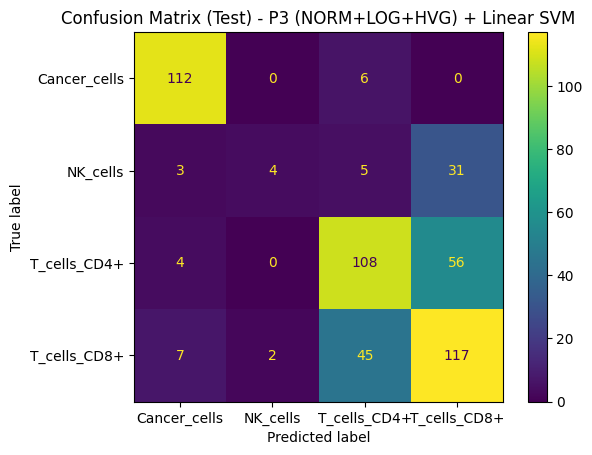

In [17]:
# -------------------------------------------------
# Model: Linear SVM (Calibrated for predict_proba)
# -------------------------------------------------
svm = LinearSVC(
    C=1.0,
    class_weight="balanced",
    random_state=42,
    max_iter=5000,
)

pipe_3_svm = Pipeline(
    [
        ("CalibratedLinearSVC", CalibratedClassifierCV(svm, method="sigmoid", cv=5)),
    ]
)

pipe_3_svm.fit(X_train_3, y_train)

y_train_pred_3 = pipe_3_svm.predict(X_train_3)
y_test_pred_3  = pipe_3_svm.predict(X_test_3)

print("P3 SVM - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred_3), 4))
print("P3 SVM - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred_3), 4))

cm_3 = confusion_matrix(y_test, y_test_pred_3, labels=pipe_3_svm.classes_)
disp_3 = ConfusionMatrixDisplay(confusion_matrix=cm_3, display_labels=pipe_3_svm.classes_)
disp_3.plot()
plt.title("Confusion Matrix (Test) - P3 (NORM+LOG+HVG) + Linear SVM")
plt.show()

### Gaussian Navies Bayes

Naive Bayes (P1) - Train balanced accuracy: 0.9927
Naive Bayes (P1) - Test  balanced accuracy: 0.5526


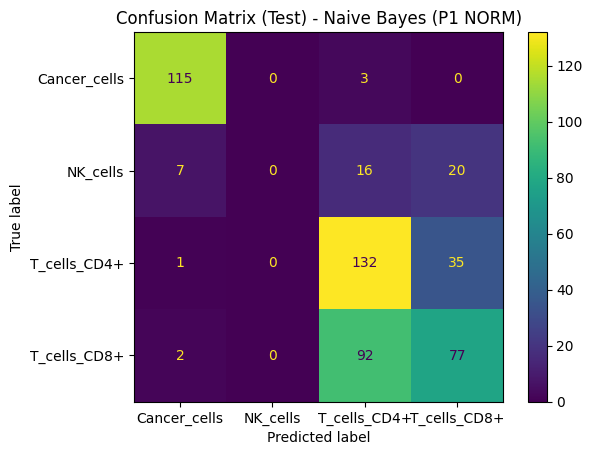

In [18]:
pipe_nb_p1 = Pipeline(
    [
        ("GaussianNB", GaussianNB(var_smoothing=1e-8)),
    ]
)

pipe_nb_p1.fit(X_train_1, y_train)

y_train_pred = pipe_nb_p1.predict(X_train_1)
y_test_pred  = pipe_nb_p1.predict(X_test_1)

print("Naive Bayes (P1) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("Naive Bayes (P1) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_nb_p1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_nb_p1.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - Naive Bayes (P1 NORM)")
plt.show()

Naive Bayes (P2) - Train balanced accuracy: 0.9927
Naive Bayes (P2) - Test  balanced accuracy: 0.5483


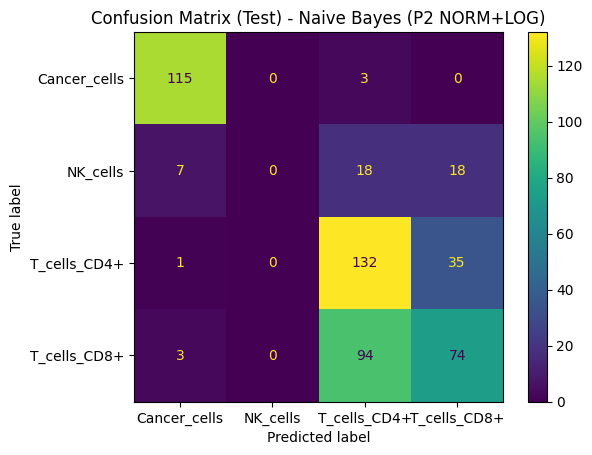

In [19]:
# =========================
# NAIVE BAYES - PIPELINE 2 (NORM + LOG1P)
# =========================

pipe_nb_p2 = Pipeline(
    [
        ("GaussianNB", GaussianNB(var_smoothing=1e-8)),
    ]
)

pipe_nb_p2.fit(X_train_2, y_train)

y_train_pred = pipe_nb_p2.predict(X_train_2)
y_test_pred  = pipe_nb_p2.predict(X_test_2)

print("Naive Bayes (P2) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("Naive Bayes (P2) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_nb_p2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_nb_p2.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - Naive Bayes (P2 NORM+LOG)")
plt.show()


Naive Bayes (P3) - Train balanced accuracy: 0.848
Naive Bayes (P3) - Test  balanced accuracy: 0.6627


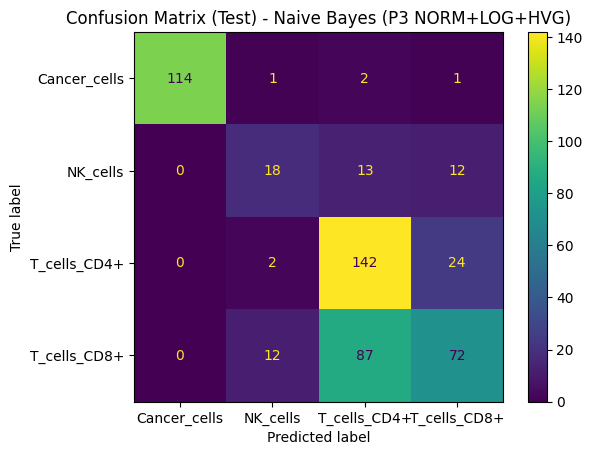

In [20]:
pipe_nb_p3 = Pipeline(
    [
        ("GaussianNB", GaussianNB(var_smoothing=1e-7)),
    ]
)

pipe_nb_p3.fit(X_train_3, y_train)

y_train_pred = pipe_nb_p3.predict(X_train_3)
y_test_pred  = pipe_nb_p3.predict(X_test_3)

print("Naive Bayes (P3) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("Naive Bayes (P3) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_nb_p3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_nb_p3.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - Naive Bayes (P3 NORM+LOG+HVG)")
plt.show()

### Random Forest

Random Forest (P3) - Train balanced accuracy: 0.9778
Random Forest (P3) - Test  balanced accuracy: 0.8321


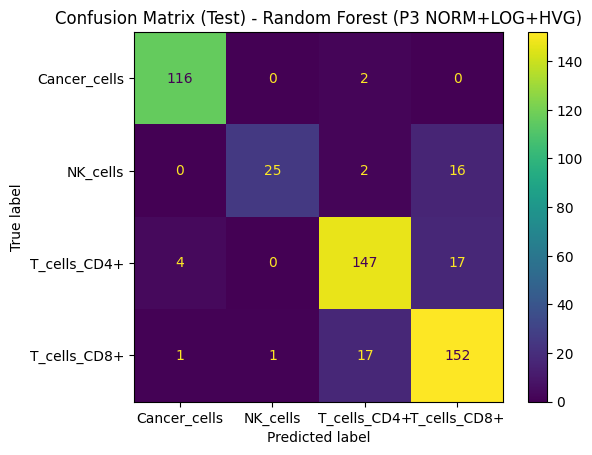

In [21]:
# -------------------------------------------------
# Model: Random Forest
# -------------------------------------------------
pipe_rf_p3 = Pipeline(
    [
        ("RandomForest", RandomForestClassifier(
            n_estimators=100,
            max_depth=None,
            max_features="sqrt",
            min_samples_leaf=7,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        )),
    ]
)

pipe_rf_p3.fit(X_train_3, y_train)

y_train_pred = pipe_rf_p3.predict(X_train_3)
y_test_pred  = pipe_rf_p3.predict(X_test_3)

print("Random Forest (P3) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("Random Forest (P3) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_rf_p3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_rf_p3.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - Random Forest (P3 NORM+LOG+HVG)")
plt.show()

In [ ]:
n_estimators_list = [50, 100, 150]
max_depth_list = [None]
max_features_list = ["sqrt", "log2"]
min_samples_leaf_list = [5, 7, 9]

best = None

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        for max_features in max_features_list:
            for min_samples_leaf in min_samples_leaf_list:
                rf = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    max_features=max_features,
                    min_samples_leaf=min_samples_leaf,
                    class_weight="balanced",
                    random_state=42,
                    n_jobs=-1,
                )

                rf.fit(X_train_3, y_train)
                y_pred = rf.predict(X_test_3)
                score = balanced_accuracy_score(y_test, y_pred)

                print(
                    f"n={n_estimators}, depth={max_depth}, feat={max_features}, leaf={min_samples_leaf} "
                    f"-> test bal acc = {score:.4f}"
                )

                if best is None or score > best["score"]:
                    best = {
                        "score": score,
                        "n_estimators": n_estimators,
                        "max_depth": max_depth,
                        "max_features": max_features,
                        "min_samples_leaf": min_samples_leaf,
                    }

print("\nBEST:")
print(best)

n=50, depth=None, feat=sqrt, leaf=5 -> test bal acc = 0.7942
n=50, depth=None, feat=sqrt, leaf=7 -> test bal acc = 0.8009
n=50, depth=None, feat=sqrt, leaf=9 -> test bal acc = 0.8160
n=50, depth=None, feat=log2, leaf=5 -> test bal acc = 0.7314
n=50, depth=None, feat=log2, leaf=7 -> test bal acc = 0.7678
n=50, depth=None, feat=log2, leaf=9 -> test bal acc = 0.7623
n=100, depth=None, feat=sqrt, leaf=5 -> test bal acc = 0.7978
n=100, depth=None, feat=sqrt, leaf=7 -> test bal acc = 0.8321
n=100, depth=None, feat=sqrt, leaf=9 -> test bal acc = 0.8233
n=100, depth=None, feat=log2, leaf=5 -> test bal acc = 0.7605
n=100, depth=None, feat=log2, leaf=7 -> test bal acc = 0.7458
n=100, depth=None, feat=log2, leaf=9 -> test bal acc = 0.7519
n=150, depth=None, feat=sqrt, leaf=5 -> test bal acc = 0.8102
n=150, depth=None, feat=sqrt, leaf=7 -> test bal acc = 0.8262
n=150, depth=None, feat=sqrt, leaf=9 -> test bal acc = 0.8247
n=150, depth=None, feat=log2, leaf=5 -> test bal acc = 0.7474
n=150, depth=N

Random Forest (P2) - Train balanced accuracy: 0.9838
Random Forest (P2) - Test  balanced accuracy: 0.7883


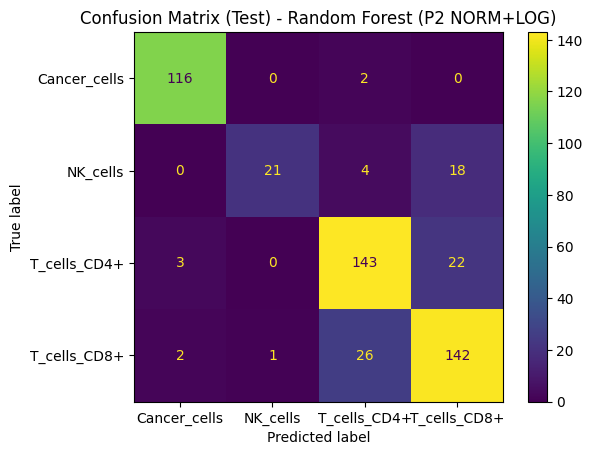

In [22]:
pipe_rf_p2 = Pipeline(
    [
        ("RandomForest", RandomForestClassifier(
            n_estimators=100,
            max_depth=None,
            max_features="sqrt",
            min_samples_leaf=7,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        )),
    ]
)

pipe_rf_p2.fit(X_train_2, y_train)

y_train_pred = pipe_rf_p2.predict(X_train_2)
y_test_pred  = pipe_rf_p2.predict(X_test_2)

print("Random Forest (P2) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("Random Forest (P2) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_rf_p2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_rf_p2.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - Random Forest (P2 NORM+LOG)")
plt.show()

Random Forest (P4) - Train balanced accuracy: 0.9815
Random Forest (P4) - Test  balanced accuracy: 0.8058


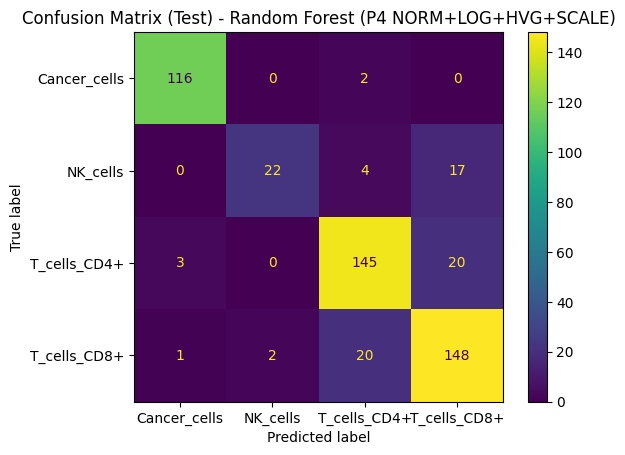

In [23]:
pipe_rf_p4 = Pipeline(
    [
        ("RandomForest", RandomForestClassifier(
            n_estimators=100,
            max_depth=None,
            max_features="sqrt",
            min_samples_leaf=7,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        )),
    ]
)

pipe_rf_p4.fit(X_train_4, y_train)

y_train_pred = pipe_rf_p4.predict(X_train_4)
y_test_pred  = pipe_rf_p4.predict(X_test_4)

print("Random Forest (P4) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("Random Forest (P4) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_rf_p4.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_rf_p4.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - Random Forest (P4 NORM+LOG+HVG+SCALE)")
plt.show()

Random Forest (P0) - Train balanced accuracy: 0.9638
Random Forest (P0) - Test  balanced accuracy: 0.7772


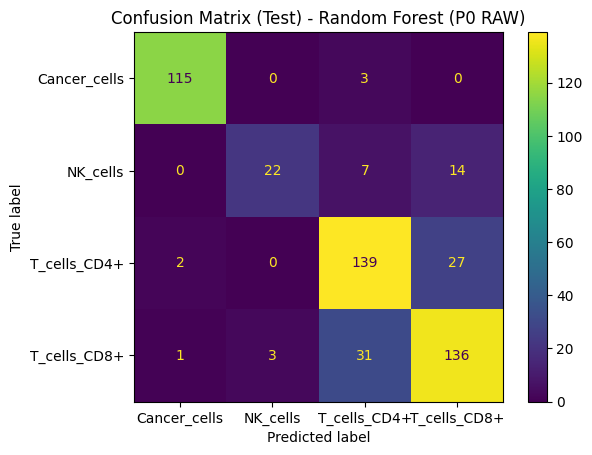

In [24]:
pipe_rf_p0 = Pipeline(
    [
        ("RandomForest", RandomForestClassifier(
            n_estimators=100,
            max_depth=None,
            max_features="sqrt",
            min_samples_leaf=7,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        )),
    ]
)

pipe_rf_p0.fit(X_train_0, y_train)

y_train_pred = pipe_rf_p0.predict(X_train_0)
y_test_pred  = pipe_rf_p0.predict(X_test_0)

print("Random Forest (P0) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("Random Forest (P0) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_rf_p0.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_rf_p0.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - Random Forest (P0 RAW)")
plt.show()

Random Forest (P5) - Train balanced accuracy: 0.9948
Random Forest (P5) - Test  balanced accuracy: 0.7101


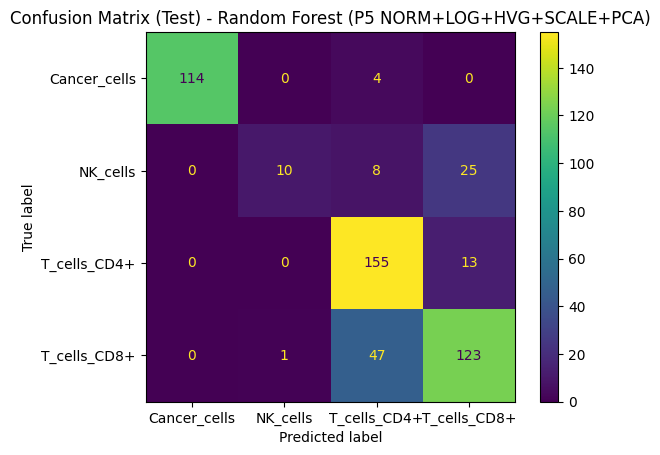

In [25]:
# =========================
# RANDOM FOREST - PIPELINE 5 (NORM + LOG1P + HVG + SCALE + PCA)
# =========================
# -------------------------------------------------
# Model: Random Forest
# -------------------------------------------------
pipe_rf_p5 = Pipeline(
    [
        ("RandomForest", RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            max_features="sqrt",
            min_samples_leaf=6,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        )),
    ]
)

pipe_rf_p5.fit(X_train_5, y_train)

y_train_pred = pipe_rf_p5.predict(X_train_5)
y_test_pred  = pipe_rf_p5.predict(X_test_5)

print("Random Forest (P5) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("Random Forest (P5) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_rf_p5.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_rf_p5.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - Random Forest (P5 NORM+LOG+HVG+SCALE+PCA)")
plt.show()


### KNN

k-NN (P4) - Train balanced accuracy: 0.4716
k-NN (P4) - Test  balanced accuracy: 0.455


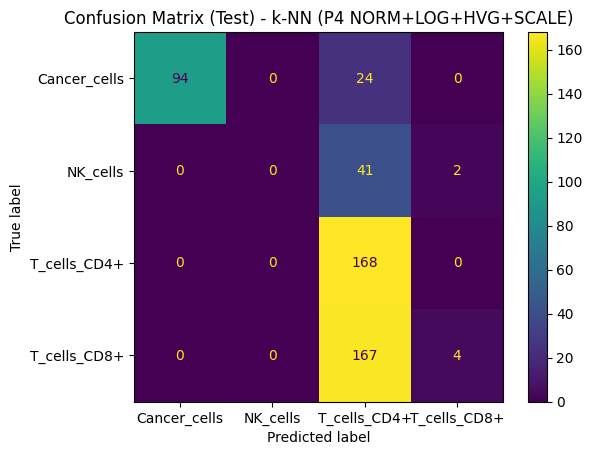

In [26]:
pipe_knn_p4 = Pipeline(
    [
        ("KNN", KNeighborsClassifier(
            n_neighbors=30,
            weights="uniform",
            metric="minkowski",
            p=2
        )),
    ]
)

pipe_knn_p4.fit(X_train_4, y_train)

y_train_pred = pipe_knn_p4.predict(X_train_4)
y_test_pred  = pipe_knn_p4.predict(X_test_4)

print("k-NN (P4) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("k-NN (P4) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_knn_p4.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_knn_p4.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - k-NN (P4 NORM+LOG+HVG+SCALE)")
plt.show()

In [ ]:
k_list = [30, 40, 50, 60, 70]
weights_list = ["uniform", "distance"]
p_list = [2]   # 1 = Manhattan, 2 = Euclidean

best = None

for k in k_list:
    for w in weights_list:
        for p in p_list:
            knn = KNeighborsClassifier(
                n_neighbors=k,
                weights=w,
                metric="minkowski",
                p=p
            )

            knn.fit(X_train_4, y_train)
            y_pred = knn.predict(X_test_4)
            score = balanced_accuracy_score(y_test, y_pred)

            print(f"k={k:<2} weights={w:<8} p={p} -> test bal acc = {score:.4f}")

            if best is None or score > best["score"]:
                best = {"score": score, "k": k, "weights": w, "p": p}

print("\nBEST:")
print(best)


k=30 weights=uniform  p=2 -> test bal acc = 0.4550
k=30 weights=distance p=2 -> test bal acc = 0.4550
k=40 weights=uniform  p=2 -> test bal acc = 0.4451
k=40 weights=distance p=2 -> test bal acc = 0.4451
k=50 weights=uniform  p=2 -> test bal acc = 0.4231
k=50 weights=distance p=2 -> test bal acc = 0.4273
k=60 weights=uniform  p=2 -> test bal acc = 0.3919
k=60 weights=distance p=2 -> test bal acc = 0.3983
k=70 weights=uniform  p=2 -> test bal acc = 0.3771
k=70 weights=distance p=2 -> test bal acc = 0.3835

BEST:
{'score': 0.45500049558925565, 'k': 30, 'weights': 'uniform', 'p': 2}


k-NN (P0) - Train balanced accuracy: 1.0
k-NN (P0) - Test  balanced accuracy: 0.6197


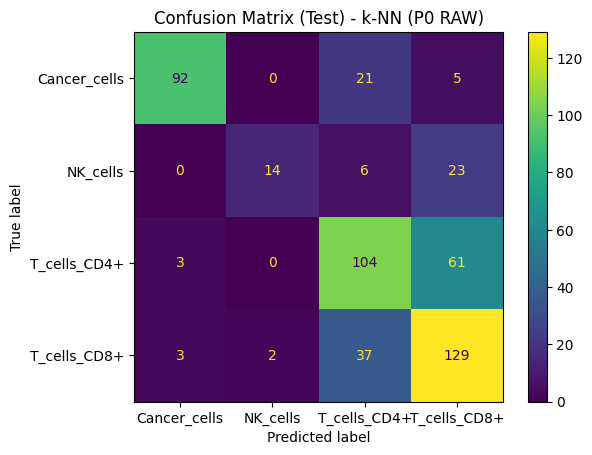

In [27]:
pipe_knn_p0 = Pipeline(
    [
        ("KNN", KNeighborsClassifier(
            n_neighbors=10,
            weights="distance",
            metric="minkowski",
            p=2
        )),
    ]
)

pipe_knn_p0.fit(X_train_0, y_train)

y_train_pred = pipe_knn_p0.predict(X_train_0)
y_test_pred  = pipe_knn_p0.predict(X_test_0)

print("k-NN (P0) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("k-NN (P0) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_knn_p0.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_knn_p0.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - k-NN (P0 RAW)")
plt.show()

k-NN (P1) - Train balanced accuracy: 1.0
k-NN (P1) - Test  balanced accuracy: 0.6324


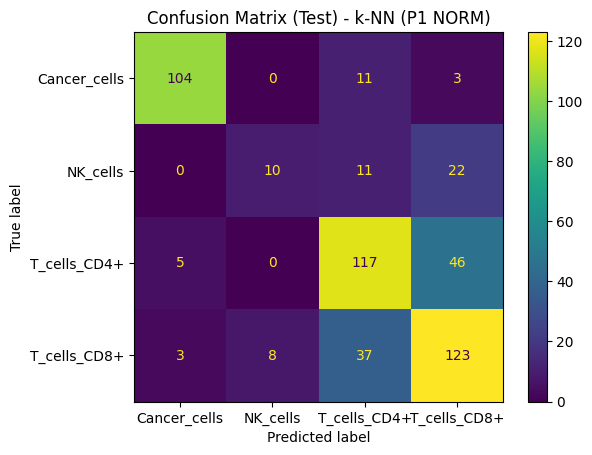

In [28]:
pipe_knn_p1 = Pipeline(
    [
        ("KNN", KNeighborsClassifier(
            n_neighbors=15,
            weights="distance",
            metric="minkowski",
            p=2
        )),
    ]
)

pipe_knn_p1.fit(X_train_1, y_train)

y_train_pred = pipe_knn_p1.predict(X_train_1)
y_test_pred  = pipe_knn_p1.predict(X_test_1)

print("k-NN (P1) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("k-NN (P1) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_knn_p1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_knn_p1.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - k-NN (P1 NORM)")
plt.show()

k-NN (P3) - Train balanced accuracy: 1.0
k-NN (P3) - Test  balanced accuracy: 0.665


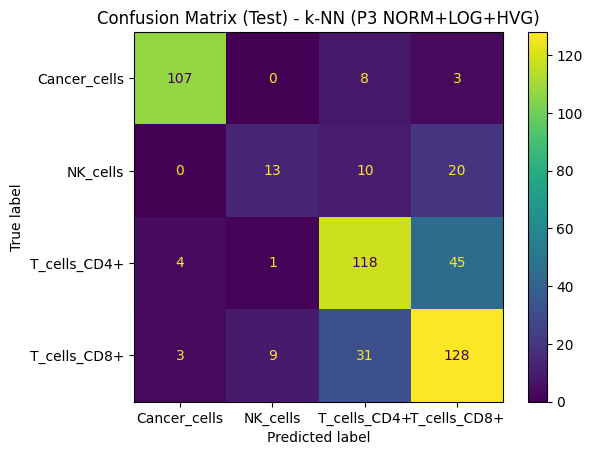

In [29]:
pipe_knn_p3 = Pipeline(
    [
        ("KNN", KNeighborsClassifier(
            n_neighbors=10,
            weights="distance",
            metric="minkowski",
            p=2
        )),
    ]
)

pipe_knn_p3.fit(X_train_3, y_train)

y_train_pred = pipe_knn_p3.predict(X_train_3)
y_test_pred  = pipe_knn_p3.predict(X_test_3)

print("k-NN (P3) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("k-NN (P3) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_knn_p3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_knn_p3.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - k-NN (P3 NORM+LOG+HVG)")
plt.show()


k-NN (P5) - Train balanced accuracy: 1.0
k-NN (P5) - Test  balanced accuracy: 0.5921


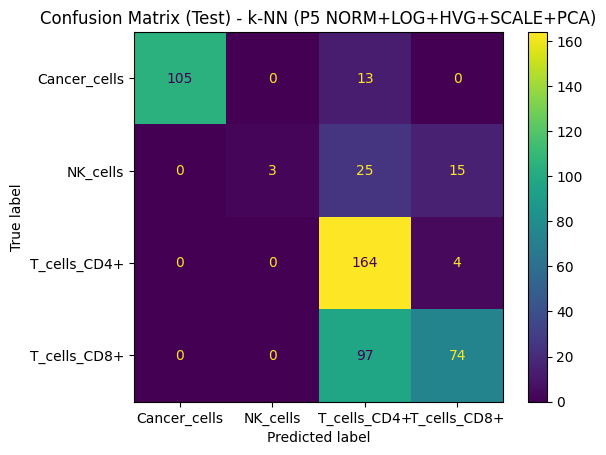

In [30]:
pipe_knn_p5 = Pipeline(
    [
        ("KNN", KNeighborsClassifier(
            n_neighbors=10,
            weights="distance",
            metric="minkowski",
            p=2
        )),
    ]
)

pipe_knn_p5.fit(X_train_5, y_train)

y_train_pred = pipe_knn_p5.predict(X_train_5)
y_test_pred  = pipe_knn_p5.predict(X_test_5)

print("k-NN (P5) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("k-NN (P5) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_knn_p5.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_knn_p5.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - k-NN (P5 NORM+LOG+HVG+SCALE+PCA)")
plt.show()


### Decision Tree

In [ ]:

max_depth_list = [5, 8, 10]
min_samples_leaf_list = [20, 25, 30]
min_samples_split_list = [2, 3]

best = None

for max_depth in max_depth_list:
    for min_leaf in min_samples_leaf_list:
        for min_split in min_samples_split_list:
            dt = DecisionTreeClassifier(
                max_depth=max_depth,
                min_samples_leaf=min_leaf,
                min_samples_split=min_split,
                class_weight="balanced",
                random_state=42,
            )

            dt.fit(X_train_3, y_train)
            y_pred = dt.predict(X_test_3)
            score = balanced_accuracy_score(y_test, y_pred)

            print(
                f"depth={max_depth}, leaf={min_leaf}, split={min_split} "
                f"-> test bal acc = {score:.4f}"
            )

            if best is None or score > best["score"]:
                best = {
                    "score": score,
                    "max_depth": max_depth,
                    "min_samples_leaf": min_leaf,
                    "min_samples_split": min_split,
                }

print("\nBEST:")
print(best)


depth=5, leaf=20, split=2 -> test bal acc = 0.7201
depth=5, leaf=20, split=3 -> test bal acc = 0.7201
depth=5, leaf=25, split=2 -> test bal acc = 0.6952
depth=5, leaf=25, split=3 -> test bal acc = 0.6952
depth=5, leaf=30, split=2 -> test bal acc = 0.6982
depth=5, leaf=30, split=3 -> test bal acc = 0.6982
depth=8, leaf=20, split=2 -> test bal acc = 0.7554
depth=8, leaf=20, split=3 -> test bal acc = 0.7554
depth=8, leaf=25, split=2 -> test bal acc = 0.6955
depth=8, leaf=25, split=3 -> test bal acc = 0.6955
depth=8, leaf=30, split=2 -> test bal acc = 0.7027
depth=8, leaf=30, split=3 -> test bal acc = 0.7027
depth=10, leaf=20, split=2 -> test bal acc = 0.7554
depth=10, leaf=20, split=3 -> test bal acc = 0.7554
depth=10, leaf=25, split=2 -> test bal acc = 0.6955
depth=10, leaf=25, split=3 -> test bal acc = 0.6955
depth=10, leaf=30, split=2 -> test bal acc = 0.7027
depth=10, leaf=30, split=3 -> test bal acc = 0.7027

BEST:
{'score': 0.755440594489772, 'max_depth': 8, 'min_samples_leaf': 20, 

Decision Tree (P3) - Train balanced accuracy: 0.8465
Decision Tree (P3) - Test  balanced accuracy: 0.7554


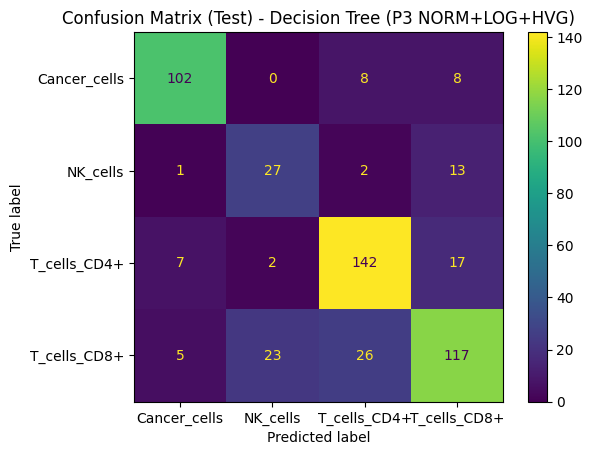

In [31]:
pipe_dt_p3 = Pipeline(
    [
        ("DecisionTree", DecisionTreeClassifier(
            max_depth=8,             
            min_samples_leaf=20,
            min_samples_split=3,
            class_weight="balanced",
            random_state=42
        )),
    ]
)

pipe_dt_p3.fit(X_train_3, y_train)

y_train_pred = pipe_dt_p3.predict(X_train_3)
y_test_pred  = pipe_dt_p3.predict(X_test_3)

print("Decision Tree (P3) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("Decision Tree (P3) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_dt_p3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_dt_p3.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - Decision Tree (P3 NORM+LOG+HVG)")
plt.show()


Decision Tree (P0) - Train balanced accuracy: 0.813
Decision Tree (P0) - Test  balanced accuracy: 0.7337


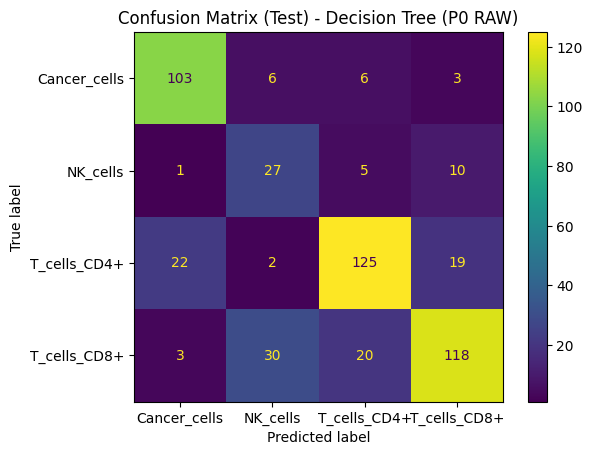

In [32]:
pipe_dt_p0 = Pipeline(
    [
        ("DecisionTree", DecisionTreeClassifier(
            max_depth=8,             
            min_samples_leaf=20,
            min_samples_split=3,
            class_weight="balanced",
            random_state=42
        )),
    ]
)

pipe_dt_p0.fit(X_train_0, y_train)
y_train_pred = pipe_dt_p0.predict(X_train_0)
y_test_pred  = pipe_dt_p0.predict(X_test_0)

print("Decision Tree (P0) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("Decision Tree (P0) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_dt_p0.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_dt_p0.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - Decision Tree (P0 RAW)")
plt.show()


Decision Tree (P1) - Train balanced accuracy: 0.8465
Decision Tree (P1) - Test  balanced accuracy: 0.7554


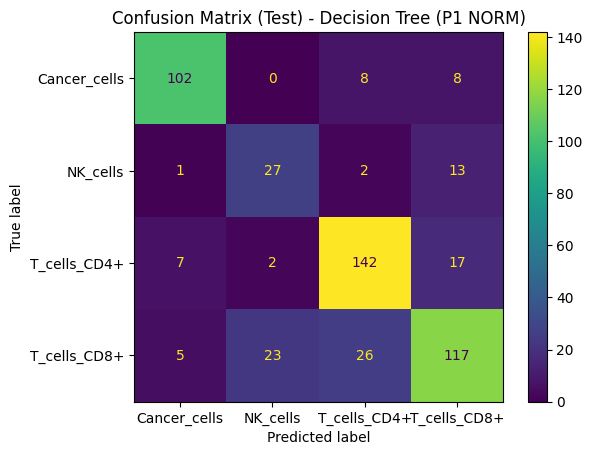

In [33]:
pipe_dt_p1 = Pipeline(
    [
        ("DecisionTree", DecisionTreeClassifier(
            max_depth=8,             
            min_samples_leaf=20,
            min_samples_split=2,
            class_weight="balanced",
            random_state=42
        )),
    ]
)

pipe_dt_p1.fit(X_train_1, y_train)
y_train_pred = pipe_dt_p1.predict(X_train_1)
y_test_pred  = pipe_dt_p1.predict(X_test_1)

print("Decision Tree (P1) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("Decision Tree (P1) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_dt_p1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_dt_p1.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - Decision Tree (P1 NORM)")
plt.show()

Decision Tree (P5) - Train balanced accuracy: 0.9113
Decision Tree (P5) - Test  balanced accuracy: 0.7119


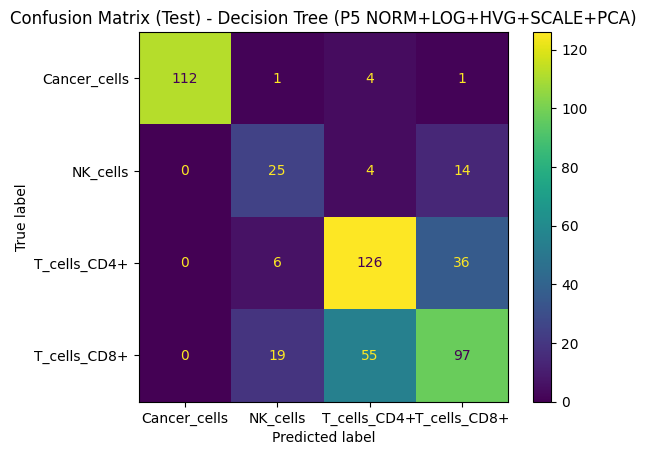

In [34]:
X_train_base = preprocess_log1p(preprocess_normalize_sum(X_train))
X_test_base  = preprocess_log1p(preprocess_normalize_sum(X_test))

top_k = 3000
gene_idx = fit_hvg_variance(X_train_base, top_k=top_k)

X_train_hvg = transform_gene_filter(X_train_base, gene_idx)
X_test_hvg  = transform_gene_filter(X_test_base, gene_idx)

mean, std = fit_standard_scaler(X_train_hvg)
X_train_scaled = transform_standard_scaler(X_train_hvg, mean, std)
X_test_scaled  = transform_standard_scaler(X_test_hvg, mean, std)

n_components = 500
pca = fit_pca(X_train_scaled, n_components=n_components)
X_train_5 = transform_pca(X_train_scaled, pca)
X_test_5  = transform_pca(X_test_scaled, pca)

pipe_dt_p5 = Pipeline(
    [
        ("DecisionTree", DecisionTreeClassifier(
            max_depth=10,
            min_samples_leaf=5,
            min_samples_split=2,
            class_weight="balanced",
            random_state=42
        )),
    ]
)

pipe_dt_p5.fit(X_train_5, y_train)
y_train_pred = pipe_dt_p5.predict(X_train_5)
y_test_pred  = pipe_dt_p5.predict(X_test_5)

print("Decision Tree (P5) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("Decision Tree (P5) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_dt_p5.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_dt_p5.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - Decision Tree (P5 NORM+LOG+HVG+SCALE+PCA)")
plt.show()

Decision Tree (P4) - Train balanced accuracy: 0.8465
Decision Tree (P4) - Test  balanced accuracy: 0.7554


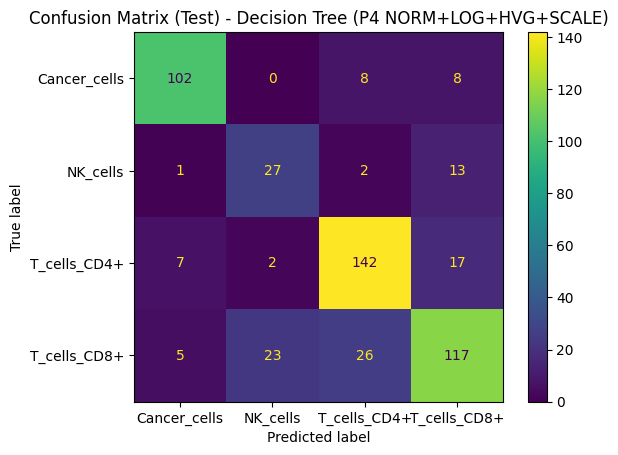

In [35]:
pipe_dt_p4 = Pipeline(
    [
        ("DecisionTree", DecisionTreeClassifier(
            max_depth=8,             
            min_samples_leaf=20,
            min_samples_split=3,
            class_weight="balanced",
            random_state=42
        )),
    ]
)

pipe_dt_p4.fit(X_train_4, y_train)
y_train_pred = pipe_dt_p4.predict(X_train_4)
y_test_pred  = pipe_dt_p4.predict(X_test_4)

print("Decision Tree (P4) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("Decision Tree (P4) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_dt_p4.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_dt_p4.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - Decision Tree (P4 NORM+LOG+HVG+SCALE)")
plt.show()

### Extra Tree

Extra Trees (P1) - Train balanced accuracy: 0.9434
Extra Trees (P1) - Test  balanced accuracy: 0.8055


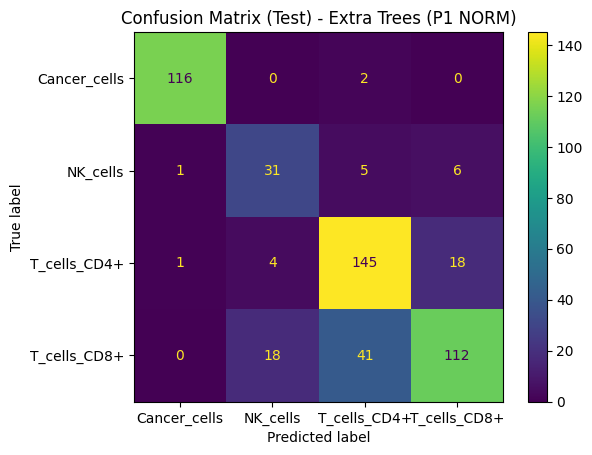

In [36]:
pipe_et_p1 = Pipeline(
    [
        ("ExtraTrees", ExtraTreesClassifier(
            n_estimators=200,
            max_depth=10,
            max_features="sqrt",
            min_samples_leaf=10,
            min_samples_split=2,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        )),
    ]
)

pipe_et_p1.fit(X_train_1, y_train)

y_train_pred = pipe_et_p1.predict(X_train_1)
y_test_pred  = pipe_et_p1.predict(X_test_1)

print("Extra Trees (P1) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("Extra Trees (P1) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_et_p1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_et_p1.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - Extra Trees (P1 NORM)")
plt.show()

In [ ]:
n_estimators_list = [200, 500, 1000]
max_depth_list = [None, 10, 20, 40]
max_features_list = ["sqrt", "log2"]
min_samples_leaf_list = [1, 2, 5, 10]
min_samples_split_list = [2, 5, 10]

best = None

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        for max_features in max_features_list:
            for min_leaf in min_samples_leaf_list:
                for min_split in min_samples_split_list:
                    et = ExtraTreesClassifier(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        max_features=max_features,
                        min_samples_leaf=min_leaf,
                        min_samples_split=min_split,
                        class_weight="balanced",
                        random_state=42,
                        n_jobs=-1,
                    )

                    et.fit(X_train_3, y_train)
                    y_pred = et.predict(X_test_3)
                    score = balanced_accuracy_score(y_test, y_pred)

                    print(
                        f"n={n_estimators}, depth={max_depth}, feat={max_features}, "
                        f"leaf={min_leaf}, split={min_split} -> test bal acc = {score:.4f}"
                    )

                    if best is None or score > best["score"]:
                        best = {
                            "score": score,
                            "n_estimators": n_estimators,
                            "max_depth": max_depth,
                            "max_features": max_features,
                            "min_samples_leaf": min_leaf,
                            "min_samples_split": min_split,
                        }

print("\nBEST:")
print(best)


n=200, depth=None, feat=sqrt, leaf=1, split=2 -> test bal acc = 0.7004
n=200, depth=None, feat=sqrt, leaf=1, split=5 -> test bal acc = 0.7207
n=200, depth=None, feat=sqrt, leaf=1, split=10 -> test bal acc = 0.7528
n=200, depth=None, feat=sqrt, leaf=2, split=2 -> test bal acc = 0.7193
n=200, depth=None, feat=sqrt, leaf=2, split=5 -> test bal acc = 0.7367
n=200, depth=None, feat=sqrt, leaf=2, split=10 -> test bal acc = 0.7397
n=200, depth=None, feat=sqrt, leaf=5, split=2 -> test bal acc = 0.7868
n=200, depth=None, feat=sqrt, leaf=5, split=5 -> test bal acc = 0.7868
n=200, depth=None, feat=sqrt, leaf=5, split=10 -> test bal acc = 0.7868
n=200, depth=None, feat=sqrt, leaf=10, split=2 -> test bal acc = 0.8129
n=200, depth=None, feat=sqrt, leaf=10, split=5 -> test bal acc = 0.8129
n=200, depth=None, feat=sqrt, leaf=10, split=10 -> test bal acc = 0.8129
n=200, depth=None, feat=log2, leaf=1, split=2 -> test bal acc = 0.6485
n=200, depth=None, feat=log2, leaf=1, split=5 -> test bal acc = 0.6643

Extra Trees (P3) - Train balanced accuracy: 0.9668
Extra Trees (P3) - Test  balanced accuracy: 0.8392


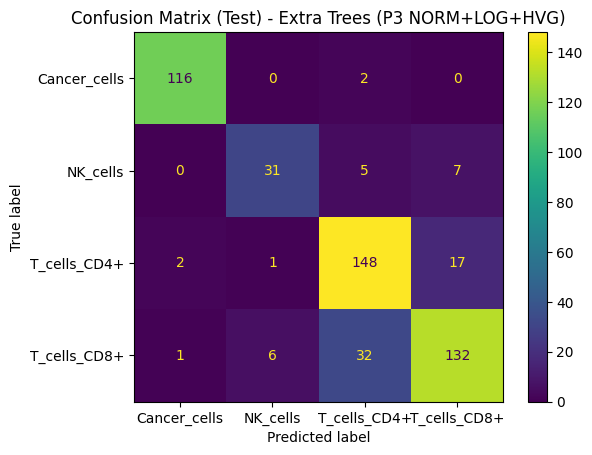

In [37]:
pipe_et_p3 = Pipeline(
    [
        ("ExtraTrees", ExtraTreesClassifier(
            n_estimators=200,
            max_depth=10,
            max_features="sqrt",
            min_samples_leaf=10,
            min_samples_split=2,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        )),
    ]
)

pipe_et_p3.fit(X_train_3, y_train)

y_train_pred = pipe_et_p3.predict(X_train_3)
y_test_pred  = pipe_et_p3.predict(X_test_3)

print("Extra Trees (P3) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("Extra Trees (P3) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_et_p3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_et_p3.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - Extra Trees (P3 NORM+LOG+HVG)")
plt.show()

Extra Trees (P5) - Train balanced accuracy: 0.9441
Extra Trees (P5) - Test  balanced accuracy: 0.6193


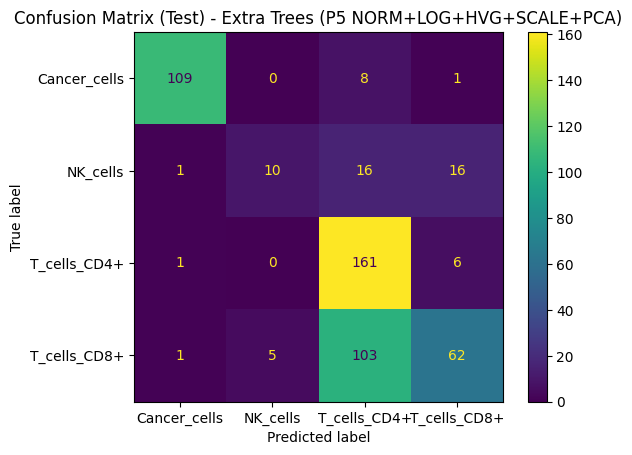

In [38]:
pipe_et_p5 = Pipeline(
    [
        ("ExtraTrees", ExtraTreesClassifier(
            n_estimators=200,
            max_depth=10,
            max_features="sqrt",
            min_samples_leaf=10,
            min_samples_split=2,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        )),
    ]
)

pipe_et_p5.fit(X_train_5, y_train)

y_train_pred = pipe_et_p5.predict(X_train_5)
y_test_pred  = pipe_et_p5.predict(X_test_5)

print("Extra Trees (P5) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("Extra Trees (P5) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_et_p5.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_et_p5.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - Extra Trees (P5 NORM+LOG+HVG+SCALE+PCA)")
plt.show()

Extra Trees (P6) - Train balanced accuracy: 0.9181
Extra Trees (P6) - Test  balanced accuracy: 0.7675


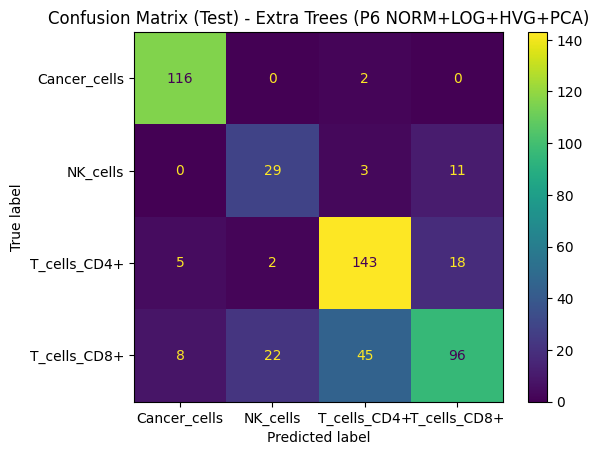

In [39]:
# -------------------------------------------------
# Step 1: normalize + log1p
# -------------------------------------------------
X_train_base = preprocess_log1p(preprocess_normalize_sum(X_train))
X_test_base  = preprocess_log1p(preprocess_normalize_sum(X_test))

# -------------------------------------------------
# Step 2: HVG fit on TRAIN ONLY
# -------------------------------------------------
top_k = 2000
gene_idx = fit_hvg_variance(X_train_base, top_k=top_k)

X_train_hvg = transform_gene_filter(X_train_base, gene_idx)
X_test_hvg  = transform_gene_filter(X_test_base, gene_idx)

# -------------------------------------------------
# Step 3: PCA fit on TRAIN ONLY  (NO scaling)
# -------------------------------------------------
n_components = 50
pca = fit_pca(X_train_hvg, n_components=n_components)

X_train_6 = transform_pca(X_train_hvg, pca)
X_test_6  = transform_pca(X_test_hvg, pca)

# -------------------------------------------------
# Model: Extra Trees (use your hyperparameters here)
# -------------------------------------------------
pipe_et_p6 = Pipeline(
    [
        ("ExtraTrees", ExtraTreesClassifier(
            n_estimators=200,
            max_depth=10,
            max_features="sqrt",
            min_samples_leaf=10,
            min_samples_split=2,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        )),
    ]
)

pipe_et_p6.fit(X_train_6, y_train)

y_train_pred = pipe_et_p6.predict(X_train_6)
y_test_pred  = pipe_et_p6.predict(X_test_6)

print("Extra Trees (P6) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("Extra Trees (P6) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_et_p6.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_et_p6.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - Extra Trees (P6 NORM+LOG+HVG+PCA)")
plt.show()

### GradientBoosting

GradientBoosting (P3) - Train balanced accuracy: 1.0
GradientBoosting (P3) - Test  balanced accuracy: 0.8302


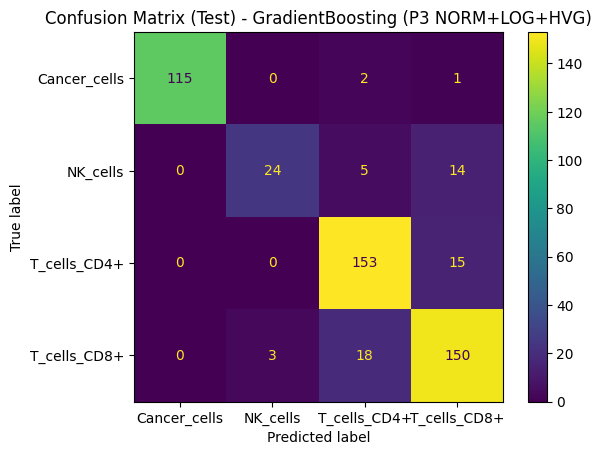

In [40]:
pipe_gb_p3 = Pipeline(
    [
        ("GB", GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.6,
            min_samples_leaf=20,
            random_state=42
        )),
    ]
)

pipe_gb_p3.fit(X_train_3, y_train)

y_train_pred = pipe_gb_p3.predict(X_train_3)
y_test_pred  = pipe_gb_p3.predict(X_test_3)

print("GradientBoosting (P3) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("GradientBoosting (P3) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_gb_p3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_gb_p3.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - GradientBoosting (P3 NORM+LOG+HVG)")
plt.show()

In [ ]:
# I have run it once already. Below, I scope to the hyperparameter that closely to the best found.
n_estimators_list = [200, 300]
learning_rate_list = [0.05]
max_depth_list = [4]
subsample_list = [0.6, 1.0]
min_samples_leaf_list = [5, 20]

best = None

for n_estimators in n_estimators_list:
    for lr in learning_rate_list:
        for md in max_depth_list:
            for subs in subsample_list:
                for leaf in min_samples_leaf_list:
                    gb = GradientBoostingClassifier(
                        n_estimators=n_estimators,
                        learning_rate=lr,
                        max_depth=md,
                        subsample=subs,
                        min_samples_leaf=leaf,
                        random_state=42,
                    )

                    gb.fit(X_train_3, y_train)
                    y_pred = gb.predict(X_test_3)
                    score = balanced_accuracy_score(y_test, y_pred)

                    print(
                        f"n={n_estimators}, lr={lr}, depth={md}, subs={subs}, leaf={leaf} "
                        f"-> test bal acc = {score:.4f}"
                    )

                    if best is None or score > best["score"]:
                        best = {
                            "score": score,
                            "n_estimators": n_estimators,
                            "learning_rate": lr,
                            "max_depth": md,
                            "subsample": subs,
                            "min_samples_leaf": leaf,
                        }

print("\nBEST:")
print(best)

n=200, lr=0.05, depth=4, subs=0.6, leaf=5 -> test bal acc = 0.8192
n=200, lr=0.05, depth=4, subs=0.6, leaf=20 -> test bal acc = 0.8302
n=200, lr=0.05, depth=4, subs=1.0, leaf=5 -> test bal acc = 0.8068
n=200, lr=0.05, depth=4, subs=1.0, leaf=20 -> test bal acc = 0.8221
n=200, lr=0.05, depth=5, subs=0.6, leaf=5 -> test bal acc = 0.8003
n=200, lr=0.05, depth=5, subs=0.6, leaf=20 -> test bal acc = 0.8171
n=200, lr=0.05, depth=5, subs=1.0, leaf=5 -> test bal acc = 0.7967
n=200, lr=0.05, depth=5, subs=1.0, leaf=20 -> test bal acc = 0.8076
n=200, lr=0.1, depth=4, subs=0.6, leaf=5 -> test bal acc = 0.8142
n=200, lr=0.1, depth=4, subs=0.6, leaf=20 -> test bal acc = 0.8273
n=200, lr=0.1, depth=4, subs=1.0, leaf=5 -> test bal acc = 0.8112
n=200, lr=0.1, depth=4, subs=1.0, leaf=20 -> test bal acc = 0.8272
n=200, lr=0.1, depth=5, subs=0.6, leaf=5 -> test bal acc = 0.8069
n=200, lr=0.1, depth=5, subs=0.6, leaf=20 -> test bal acc = 0.8243
n=200, lr=0.1, depth=5, subs=1.0, leaf=5 -> test bal acc = 0.

GradientBoosting (P4) - Train balanced accuracy: 1.0
GradientBoosting (P4) - Test  balanced accuracy: 0.8215


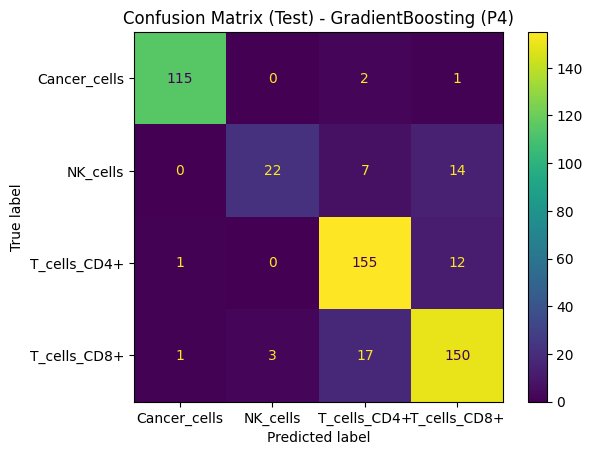

In [41]:
pipe_gb_p4 = Pipeline(
    [
        ("GB", GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.6,
            min_samples_leaf=20,
            random_state=42
        )),
    ]
)

pipe_gb_p4.fit(X_train_4, y_train)

y_train_pred = pipe_gb_p4.predict(X_train_4)
y_test_pred  = pipe_gb_p4.predict(X_test_4)

print("GradientBoosting (P4) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("GradientBoosting (P4) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_gb_p4.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_gb_p4.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - GradientBoosting (P4)")
plt.show()

GradientBoosting (P6) - Train balanced accuracy: 1.0
GradientBoosting (P6) - Test  balanced accuracy: 0.7443


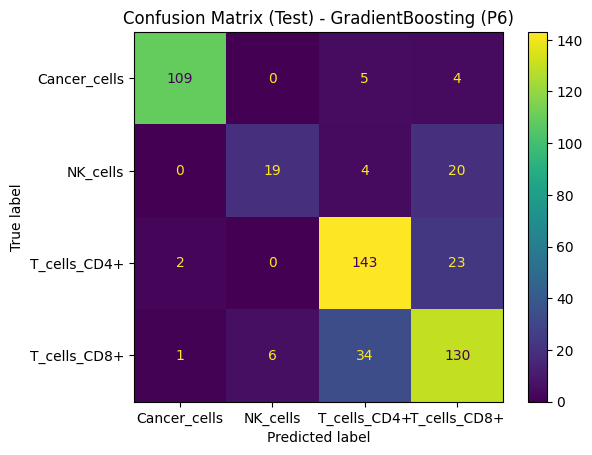

In [42]:
pipe_gb_p6 = Pipeline(
    [
        ("GB", GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.6,
            min_samples_leaf=20,
            random_state=42
        )),
    ]
)

pipe_gb_p6.fit(X_train_6, y_train)

y_train_pred = pipe_gb_p6.predict(X_train_6)
y_test_pred  = pipe_gb_p6.predict(X_test_6)

print("GradientBoosting (P6) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("GradientBoosting (P6) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_gb_p6.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_gb_p6.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - GradientBoosting (P6)")
plt.show()

### HistGradient

HistGradientBoosting (P3) - Train balanced accuracy: 0.9823
HistGradientBoosting (P3) - Test  balanced accuracy: 0.7988


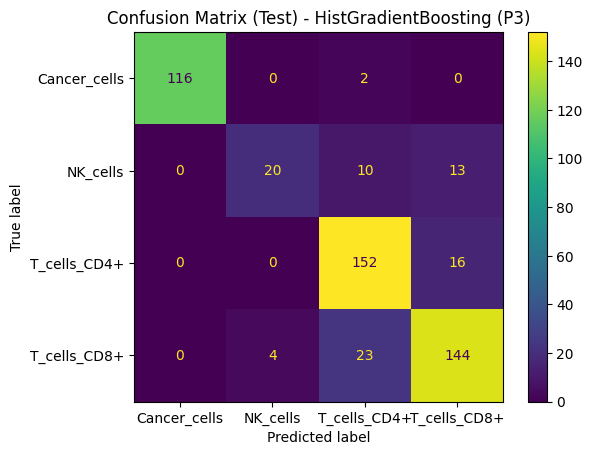

In [ ]:
pipe_hgb_p3 = Pipeline(
    [
        ("HGB", HistGradientBoostingClassifier(
            learning_rate=0.1,
            max_depth=3,
            max_leaf_nodes=31,
            min_samples_leaf=20,
            l2_regularization=1,
            early_stopping=True,
            random_state=42
        )),
    ]
)

pipe_hgb_p3.fit(X_train_3, y_train)

y_train_pred = pipe_hgb_p3.predict(X_train_3)
y_test_pred  = pipe_hgb_p3.predict(X_test_3)

print("HistGradientBoosting (P3) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("HistGradientBoosting (P3) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_hgb_p3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_hgb_p3.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - HistGradientBoosting (P3)")
plt.show()

In [ ]:
learning_rate_list = [0.01, 0.05, 0.1]
max_depth_list = [3, 6, 9]
min_samples_leaf_list = [10, 20, 40]
l2_list = [0.0, 0.1, 0.5, 1.0]

best = None

for lr in learning_rate_list:
    for md in max_depth_list:
        for leaf in min_samples_leaf_list:
            for l2 in l2_list:
                hgb = HistGradientBoostingClassifier(
                    learning_rate=lr,
                    max_depth=md,
                    max_leaf_nodes=31,
                    min_samples_leaf=leaf,
                    l2_regularization=l2,
                    early_stopping=True,
                    random_state=42
                )
                hgb.fit(X_train_3, y_train)
                y_pred = hgb.predict(X_test_3)
                score = balanced_accuracy_score(y_test, y_pred)

                print(f"lr={lr}, depth={md}, leaf={leaf}, l2={l2} -> {score:.4f}")

                if best is None or score > best["score"]:
                    best = {"score": score, "lr": lr, "depth": md, "leaf": leaf, "l2": l2}

print("\nBEST:", best)

lr=0.01, depth=3, leaf=10, l2=0.0 -> 0.7547
lr=0.01, depth=3, leaf=10, l2=0.1 -> 0.7540
lr=0.01, depth=3, leaf=10, l2=0.5 -> 0.7532
lr=0.01, depth=3, leaf=10, l2=1.0 -> 0.7511
lr=0.01, depth=3, leaf=20, l2=0.0 -> 0.7641
lr=0.01, depth=3, leaf=20, l2=0.1 -> 0.7627
lr=0.01, depth=3, leaf=20, l2=0.5 -> 0.7568
lr=0.01, depth=3, leaf=20, l2=1.0 -> 0.7539
lr=0.01, depth=3, leaf=40, l2=0.0 -> 0.7624
lr=0.01, depth=3, leaf=40, l2=0.1 -> 0.7624
lr=0.01, depth=3, leaf=40, l2=0.5 -> 0.7618
lr=0.01, depth=3, leaf=40, l2=1.0 -> 0.7560
lr=0.01, depth=6, leaf=10, l2=0.0 -> 0.7481
lr=0.01, depth=6, leaf=10, l2=0.1 -> 0.7518
lr=0.01, depth=6, leaf=10, l2=0.5 -> 0.7548
lr=0.01, depth=6, leaf=10, l2=1.0 -> 0.7540
lr=0.01, depth=6, leaf=20, l2=0.0 -> 0.7764
lr=0.01, depth=6, leaf=20, l2=0.1 -> 0.7770
lr=0.01, depth=6, leaf=20, l2=0.5 -> 0.7726
lr=0.01, depth=6, leaf=20, l2=1.0 -> 0.7771
lr=0.01, depth=6, leaf=40, l2=0.0 -> 0.7698
lr=0.01, depth=6, leaf=40, l2=0.1 -> 0.7698
lr=0.01, depth=6, leaf=40, l2=0.

HistGradientBoosting (P4) - Train balanced accuracy: 0.9823
HistGradientBoosting (P4) - Test  balanced accuracy: 0.8003


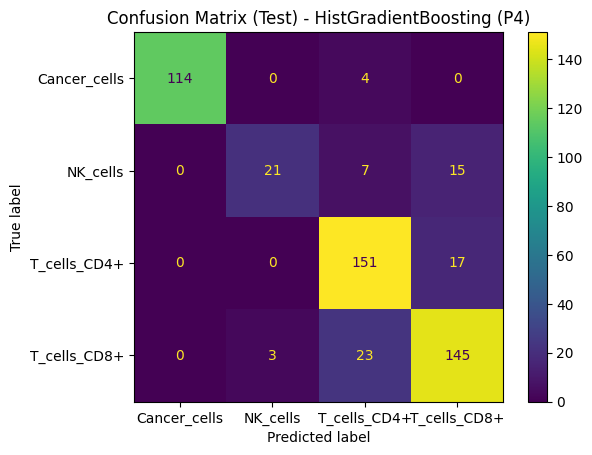

In [44]:
pipe_hgb_p4 = Pipeline(
    [
        ("HGB", HistGradientBoostingClassifier(
            learning_rate=0.1,
            max_depth=3,
            max_leaf_nodes=31,
            min_samples_leaf=20,
            l2_regularization=1.0,
            early_stopping=True,
            random_state=42
        )),
    ]
)

pipe_hgb_p4.fit(X_train_4, y_train)

y_train_pred = pipe_hgb_p4.predict(X_train_4)
y_test_pred  = pipe_hgb_p4.predict(X_test_4)

print("HistGradientBoosting (P4) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("HistGradientBoosting (P4) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_hgb_p4.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_hgb_p4.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - HistGradientBoosting (P4)")
plt.show()

HistGradientBoosting (P5) - Train balanced accuracy: 0.9713
HistGradientBoosting (P5) - Test  balanced accuracy: 0.7269


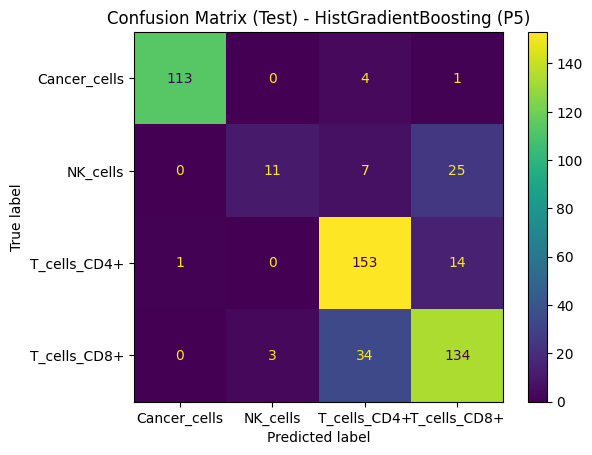

In [45]:
# normalize + log1p
X_train_base = preprocess_log1p(preprocess_normalize_sum(X_train))
X_test_base  = preprocess_log1p(preprocess_normalize_sum(X_test))

# HVG fit on TRAIN ONLY
top_k = 2000
gene_idx = fit_hvg_variance(X_train_base, top_k=top_k)

X_train_hvg = transform_gene_filter(X_train_base, gene_idx)
X_test_hvg  = transform_gene_filter(X_test_base, gene_idx)

# scaling fit on TRAIN ONLY
mean, std = fit_standard_scaler(X_train_hvg)
X_train_scaled = transform_standard_scaler(X_train_hvg, mean, std)
X_test_scaled  = transform_standard_scaler(X_test_hvg, mean, std)

# PCA fit on TRAIN ONLY
n_components = 500
pca = fit_pca(X_train_scaled, n_components=n_components)
X_train_5 = transform_pca(X_train_scaled, pca)
X_test_5  = transform_pca(X_test_scaled, pca)

pipe_hgb_p5 = Pipeline(
    [
        ("HGB", HistGradientBoostingClassifier(
            learning_rate=0.1,
            max_depth=3,
            max_leaf_nodes=31,
            min_samples_leaf=20,
            l2_regularization=1.0,
            early_stopping=True,
            random_state=42
        )),
    ]
)

pipe_hgb_p5.fit(X_train_5, y_train)

y_train_pred = pipe_hgb_p5.predict(X_train_5)
y_test_pred  = pipe_hgb_p5.predict(X_test_5)

print("HistGradientBoosting (P5) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("HistGradientBoosting (P5) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_hgb_p5.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_hgb_p5.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - HistGradientBoosting (P5)")
plt.show()

HistGradientBoosting (P6) - Train balanced accuracy: 0.9772
HistGradientBoosting (P6) - Test  balanced accuracy: 0.7426


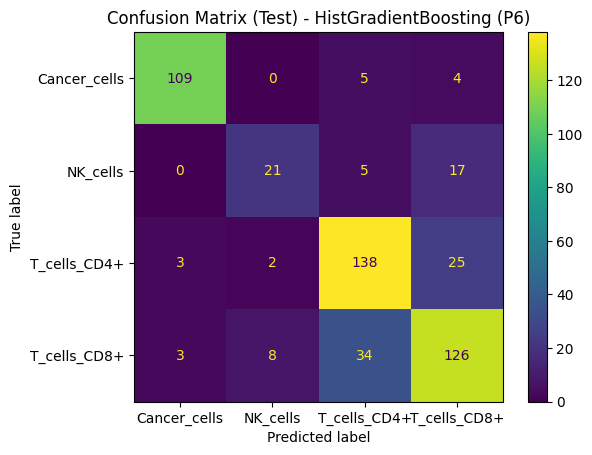

In [46]:
# normalize + log1p
X_train_base = preprocess_log1p(preprocess_normalize_sum(X_train))
X_test_base  = preprocess_log1p(preprocess_normalize_sum(X_test))

# HVG fit on TRAIN ONLY
top_k = 2000
gene_idx = fit_hvg_variance(X_train_base, top_k=top_k)

X_train_hvg = transform_gene_filter(X_train_base, gene_idx)
X_test_hvg  = transform_gene_filter(X_test_base, gene_idx)

# PCA fit on TRAIN ONLY (NO scaling)
n_components = 50
pca = fit_pca(X_train_hvg, n_components=n_components)
X_train_6 = transform_pca(X_train_hvg, pca)
X_test_6  = transform_pca(X_test_hvg, pca)

pipe_hgb_p6 = Pipeline(
    [
        ("HGB", HistGradientBoostingClassifier(
            learning_rate=0.1,
            max_depth=3,
            max_leaf_nodes=31,
            min_samples_leaf=20,
            l2_regularization=1.0,
            early_stopping=True,
            random_state=42
        )),
    ]
)

pipe_hgb_p6.fit(X_train_6, y_train)

y_train_pred = pipe_hgb_p6.predict(X_train_6)
y_test_pred  = pipe_hgb_p6.predict(X_test_6)

print("HistGradientBoosting (P6) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("HistGradientBoosting (P6) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_hgb_p6.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_hgb_p6.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - HistGradientBoosting (P6)")
plt.show()

HistGradientBoosting (P1) - Train balanced accuracy: 0.9823
HistGradientBoosting (P1) - Test  balanced accuracy: 0.8097


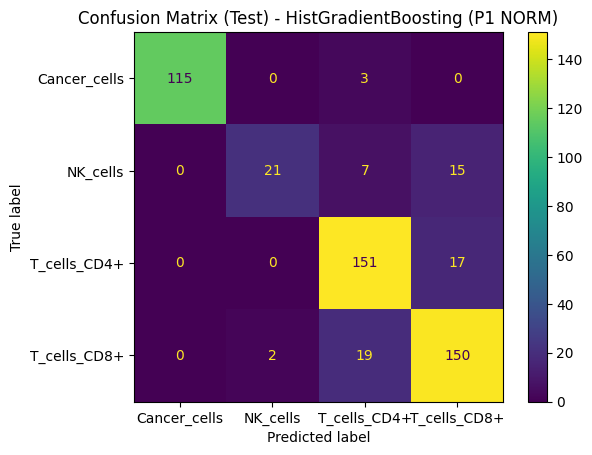

In [47]:
pipe_hgb_p1 = Pipeline(
    [
        ("HGB", HistGradientBoostingClassifier(
            learning_rate=0.1,
            max_depth=3,
            max_leaf_nodes=31,
            min_samples_leaf=20,
            l2_regularization=1.0,
            early_stopping=True,
            random_state=42
        )),
    ]
)

pipe_hgb_p1.fit(X_train_1, y_train)

y_train_pred = pipe_hgb_p1.predict(X_train_1)
y_test_pred  = pipe_hgb_p1.predict(X_test_1)

print("HistGradientBoosting (P1) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("HistGradientBoosting (P1) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_hgb_p1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_hgb_p1.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - HistGradientBoosting (P1 NORM)")
plt.show()

### XGBoosting

XGB (P3) - Train balanced accuracy: 1.0
XGB (P3) - Test  balanced accuracy: 0.8469


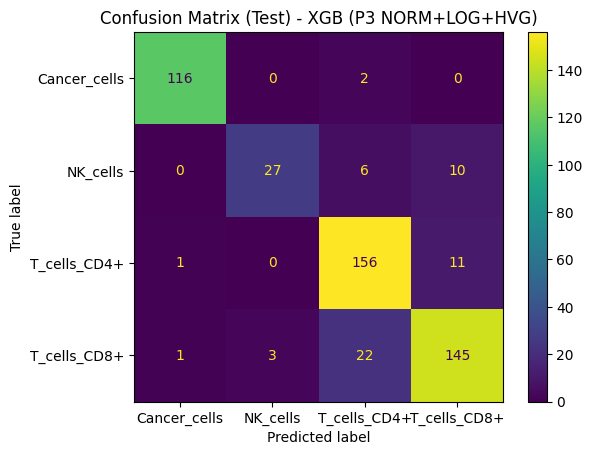

In [48]:
# 1) Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

# 2) Sample weights (use encoded labels)
sw = compute_sample_weight(class_weight="balanced", y=y_train_enc)

# 3) Fit XGB
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=7,
    subsample=0.6,
    colsample_bytree=0.4,
    reg_lambda=1.0,
    reg_alpha=0.0,
    min_child_weight=1,
    gamma=0.0,
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",
    n_jobs=-1,
    random_state=42
)

xgb.fit(X_train_3, y_train_enc, sample_weight=sw)

# 4) Predict (encoded)
y_train_pred_enc = xgb.predict(X_train_3)
y_test_pred_enc  = xgb.predict(X_test_3)

print("XGB (P3) - Train balanced accuracy:", round(balanced_accuracy_score(y_train_enc, y_train_pred_enc), 4))
print("XGB (P3) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test_enc, y_test_pred_enc), 4))

# 5) Confusion matrix (decoded labels for display)
labels_enc = list(range(len(le.classes_)))
cm = confusion_matrix(y_test_enc, y_test_pred_enc, labels=labels_enc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - XGB (P3 NORM+LOG+HVG)")
plt.show()

In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

# sample weights on TRAIN
sw_train = compute_sample_weight(class_weight="balanced", y=y_train_enc)

# --------------------------
# Grid
# --------------------------
depth_list = [3, 5, 7, 9]
lr_list = [0.03, 0.05, 0.1]
n_list = [200]
colsample_list = [0.4, 0.6]
subsample_list = [0.6]

best = None

for md in depth_list:
    for lr in lr_list:
        for n in n_list:
            for col in colsample_list:
                for subs in subsample_list:
                    xgb = XGBClassifier(
                        n_estimators=n,
                        learning_rate=lr,
                        max_depth=md,
                        subsample=subs,
                        colsample_bytree=col,
                        reg_lambda=1.0,
                        reg_alpha=0.0,
                        min_child_weight=1,
                        gamma=0.0,
                        objective="multi:softprob",
                        eval_metric="mlogloss",
                        tree_method="hist",
                        n_jobs=-1,
                        random_state=42,
                    )

                    xgb.fit(X_train_3, y_train_enc, sample_weight=sw_train)

                    y_test_pred = xgb.predict(X_test_3)
                    score = balanced_accuracy_score(y_test_enc, y_test_pred)

                    print(f"depth={md}, lr={lr}, n={n}, col={col}, subs={subs} -> TEST bal acc = {score:.4f}")

                    if best is None or score > best["score"]:
                        best = {
                            "score": score,
                            "max_depth": md,
                            "learning_rate": lr,
                            "n_estimators": n,
                            "colsample_bytree": col,
                            "subsample": subs,
                        }

print("\nBEST on TEST:")
print(best)

depth=3, lr=0.03, n=200, col=0.4, subs=0.6 -> TEST bal acc = 0.8185
depth=3, lr=0.03, n=200, col=0.6, subs=0.6 -> TEST bal acc = 0.8220
depth=3, lr=0.05, n=200, col=0.4, subs=0.6 -> TEST bal acc = 0.8265
depth=3, lr=0.05, n=200, col=0.6, subs=0.6 -> TEST bal acc = 0.8309
depth=3, lr=0.1, n=200, col=0.4, subs=0.6 -> TEST bal acc = 0.8322
depth=3, lr=0.1, n=200, col=0.6, subs=0.6 -> TEST bal acc = 0.8206
depth=5, lr=0.03, n=200, col=0.4, subs=0.6 -> TEST bal acc = 0.8171
depth=5, lr=0.03, n=200, col=0.6, subs=0.6 -> TEST bal acc = 0.8352
depth=5, lr=0.05, n=200, col=0.4, subs=0.6 -> TEST bal acc = 0.8367
depth=5, lr=0.05, n=200, col=0.6, subs=0.6 -> TEST bal acc = 0.8221
depth=5, lr=0.1, n=200, col=0.4, subs=0.6 -> TEST bal acc = 0.8324
depth=5, lr=0.1, n=200, col=0.6, subs=0.6 -> TEST bal acc = 0.8235
depth=7, lr=0.03, n=200, col=0.4, subs=0.6 -> TEST bal acc = 0.8206
depth=7, lr=0.03, n=200, col=0.6, subs=0.6 -> TEST bal acc = 0.8352
depth=7, lr=0.05, n=200, col=0.4, subs=0.6 -> TEST b

### AdaBoost

AdaBoost (P3) - Train balanced accuracy: 0.9963
AdaBoost (P3) - Test  balanced accuracy: 0.8416


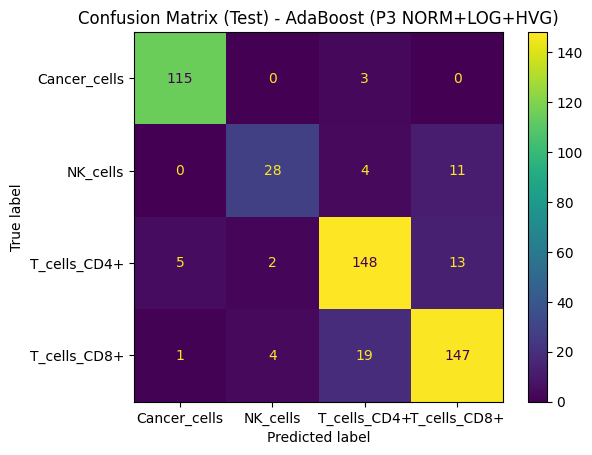

In [51]:
base_tree = DecisionTreeClassifier(
    max_depth=8,
    min_samples_leaf=20,
    min_samples_split=2,
    class_weight="balanced",
    random_state=42
)

pipe_ada_p3 = Pipeline(
    [
        ("AdaBoost", AdaBoostClassifier(
            estimator=base_tree,
            n_estimators=100,
            learning_rate=0.03,
            algorithm="SAMME",
            random_state=42
        )),
    ]
)

pipe_ada_p3.fit(X_train_3, y_train)

y_train_pred = pipe_ada_p3.predict(X_train_3)
y_test_pred  = pipe_ada_p3.predict(X_test_3)

print("AdaBoost (P3) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("AdaBoost (P3) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_ada_p3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_ada_p3.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - AdaBoost (P3 NORM+LOG+HVG)")
plt.show()

In [50]:
n_estimators_list = [50, 100, 200, 400]
learning_rate_list = [0.01, 0.03, 0.05, 0.1]
algorithm_list = ["SAMME"]

best = None

for algo in algorithm_list:
    for n in n_estimators_list:
        for lr in learning_rate_list:
            try:
                ada = AdaBoostClassifier(
                    estimator=base_tree,
                    n_estimators=n,
                    learning_rate=lr,
                    algorithm=algo,
                    random_state=42
                )

                ada.fit(X_train_3, y_train)

                y_pred = ada.predict(X_test_3)
                score = balanced_accuracy_score(y_test, y_pred)

                print(f"algo={algo}, n={n}, lr={lr} -> test bal acc = {score:.4f}")

                if best is None or score > best["score"]:
                    best = {"score": score, "algorithm": algo, "n_estimators": n, "learning_rate": lr}

            except Exception as e:
                print(f"SKIP algo={algo}, n={n}, lr={lr}  ({e})")

print("\nBEST:")
print(best)

algo=SAMME, n=50, lr=0.01 -> test bal acc = 0.7714
algo=SAMME, n=50, lr=0.03 -> test bal acc = 0.8102
algo=SAMME, n=50, lr=0.05 -> test bal acc = 0.8263
algo=SAMME, n=50, lr=0.1 -> test bal acc = 0.8271
algo=SAMME, n=100, lr=0.01 -> test bal acc = 0.7826
algo=SAMME, n=100, lr=0.03 -> test bal acc = 0.8416
algo=SAMME, n=100, lr=0.05 -> test bal acc = 0.8308
algo=SAMME, n=100, lr=0.1 -> test bal acc = 0.8221
algo=SAMME, n=200, lr=0.01 -> test bal acc = 0.8321
algo=SAMME, n=200, lr=0.03 -> test bal acc = 0.8323
algo=SAMME, n=200, lr=0.05 -> test bal acc = 0.8090
algo=SAMME, n=200, lr=0.1 -> test bal acc = 0.8112
algo=SAMME, n=400, lr=0.01 -> test bal acc = 0.8263
algo=SAMME, n=400, lr=0.03 -> test bal acc = 0.8162
algo=SAMME, n=400, lr=0.05 -> test bal acc = 0.8149
algo=SAMME, n=400, lr=0.1 -> test bal acc = 0.8084


h:\scmark-classification-data-shinobi\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


algo=SAMME.R, n=50, lr=0.01 -> test bal acc = 0.7436


h:\scmark-classification-data-shinobi\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


algo=SAMME.R, n=50, lr=0.03 -> test bal acc = 0.7260


h:\scmark-classification-data-shinobi\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


algo=SAMME.R, n=50, lr=0.05 -> test bal acc = 0.7297


h:\scmark-classification-data-shinobi\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


algo=SAMME.R, n=50, lr=0.1 -> test bal acc = 0.6708


h:\scmark-classification-data-shinobi\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


algo=SAMME.R, n=100, lr=0.01 -> test bal acc = 0.7320


h:\scmark-classification-data-shinobi\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


algo=SAMME.R, n=100, lr=0.03 -> test bal acc = 0.6968


h:\scmark-classification-data-shinobi\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


algo=SAMME.R, n=100, lr=0.05 -> test bal acc = 0.7240


h:\scmark-classification-data-shinobi\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


algo=SAMME.R, n=100, lr=0.1 -> test bal acc = 0.6203


h:\scmark-classification-data-shinobi\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


algo=SAMME.R, n=200, lr=0.01 -> test bal acc = 0.7198


h:\scmark-classification-data-shinobi\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


algo=SAMME.R, n=200, lr=0.03 -> test bal acc = 0.6736


h:\scmark-classification-data-shinobi\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


algo=SAMME.R, n=200, lr=0.05 -> test bal acc = 0.7125


h:\scmark-classification-data-shinobi\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


algo=SAMME.R, n=200, lr=0.1 -> test bal acc = 0.6002


h:\scmark-classification-data-shinobi\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


algo=SAMME.R, n=400, lr=0.01 -> test bal acc = 0.7080


h:\scmark-classification-data-shinobi\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


algo=SAMME.R, n=400, lr=0.03 -> test bal acc = 0.6868


h:\scmark-classification-data-shinobi\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


algo=SAMME.R, n=400, lr=0.05 -> test bal acc = 0.7248


h:\scmark-classification-data-shinobi\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


algo=SAMME.R, n=400, lr=0.1 -> test bal acc = 0.6064

BEST:
{'score': 0.8415851414108784, 'algorithm': 'SAMME', 'n_estimators': 100, 'learning_rate': 0.03}


AdaBoost (P6) - Train balanced accuracy: 0.982
AdaBoost (P6) - Test  balanced accuracy: 0.7585


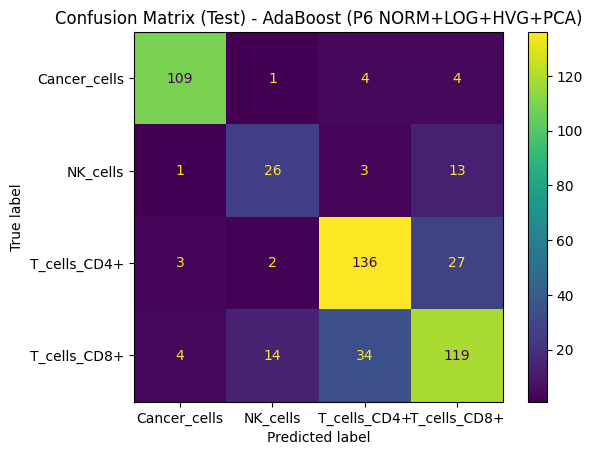

In [52]:
pipe_ada_p6 = Pipeline(
    [
        ("AdaBoost", AdaBoostClassifier(
            estimator=base_tree,
            n_estimators=100,
            learning_rate=0.03,
            algorithm="SAMME",
            random_state=42
        )),
    ]
)

pipe_ada_p6.fit(X_train_6, y_train)

y_train_pred = pipe_ada_p6.predict(X_train_6)
y_test_pred  = pipe_ada_p6.predict(X_test_6)

print("AdaBoost (P6) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("AdaBoost (P6) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_ada_p6.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_ada_p6.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - AdaBoost (P6 NORM+LOG+HVG+PCA)")
plt.show()

### LightGBM

[LightGBM] [Info] Total Bins 178519
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 1985
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

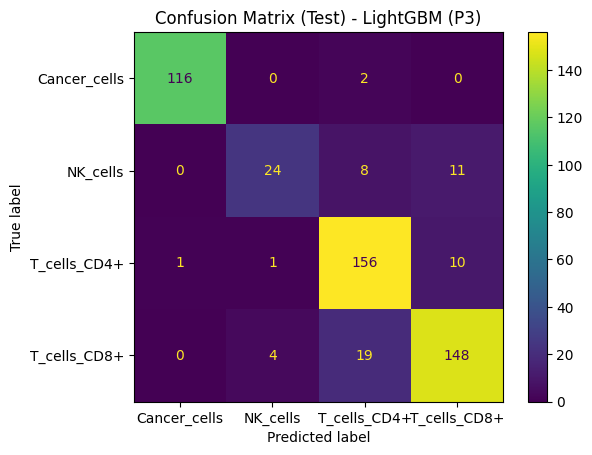

In [83]:
lgbm = LGBMClassifier(
    force_col_wise=True,
    objective="multiclass",
    num_class=len(le.classes_),
    n_estimators=200,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.6,
    colsample_bytree=0.4,
    reg_lambda=5.0,
    reg_alpha=0.0,
    random_state=42,
    n_jobs=-1
)

lgbm.fit(X_train_3, y_train_enc, sample_weight=sw)

y_train_pred = lgbm.predict(X_train_3)
y_test_pred  = lgbm.predict(X_test_3)

print("LGBM (P3) - Train balanced accuracy:", round(balanced_accuracy_score(y_train_enc, y_train_pred), 4))
print("LGBM (P3) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test_enc, y_test_pred), 4))

cm = confusion_matrix(y_test_enc, y_test_pred, labels=list(range(len(le.classes_))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - LightGBM (P3)")
plt.show()

In [68]:
num_leaves_list = [31]
max_depth_list = [7, 9]
min_child_samples_list = [20]
reg_lambda_list = [1.0, 5.0]

best = None

for leaves in num_leaves_list:
    for md in max_depth_list:
        for mcs in min_child_samples_list:
            for rl in reg_lambda_list:
                lgbm = LGBMClassifier(
                    objective="multiclass",
                    num_class=len(le.classes_),
                    n_estimators=300,
                    learning_rate=0.05,
                    max_depth=md,
                    num_leaves=leaves,
                    min_child_samples=mcs,
                    subsample=0.8,
                    colsample_bytree=0.6,
                    reg_lambda=rl,
                    reg_alpha=0.0,
                    random_state=42,
                    n_jobs=-1,
                    force_col_wise=True
                )

                lgbm.fit(X_train_3, y_train_enc, sample_weight=sw)

                y_test_pred = lgbm.predict(X_test_3)
                score = balanced_accuracy_score(y_test_enc, y_test_pred)

                print(f"leaves={leaves}, depth={md}, min_child={mcs}, lambda={rl} -> test = {score:.4f}")

                if best is None or score > best["score"]:
                    best = {"score": score, "num_leaves": leaves, "max_depth": md,
                            "min_child_samples": mcs, "reg_lambda": rl}

print("\nBEST:", best)


[LightGBM] [Info] Total Bins 178519
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 1985
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 50
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

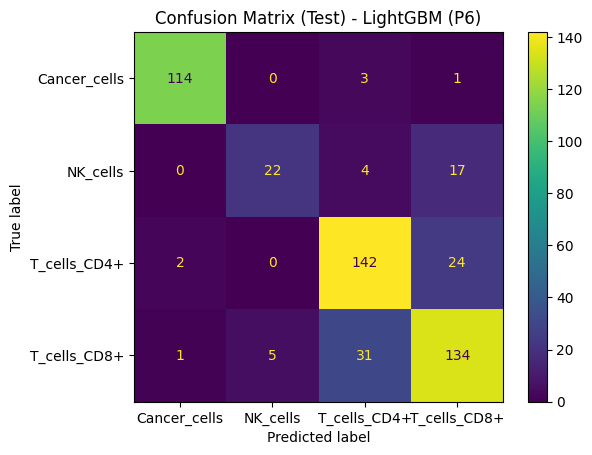

In [ ]:
lgbm = LGBMClassifier(
    objective="multiclass",
    num_class=len(le.classes_),
    n_estimators=200,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.6,
    colsample_bytree=0.4,
    reg_lambda=1.0,
    reg_alpha=0.0,
    random_state=42,
    n_jobs=-1
)

lgbm.fit(X_train_6, y_train_enc, sample_weight=sw)

y_train_pred = lgbm.predict(X_train_6)
y_test_pred  = lgbm.predict(X_test_6)

print("LGBM (P6) - Train balanced accuracy:", round(balanced_accuracy_score(y_train_enc, y_train_pred), 4))
print("LGBM (P6) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test_enc, y_test_pred), 4))

cm = confusion_matrix(y_test_enc, y_test_pred, labels=list(range(len(le.classes_))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - LightGBM (P6)")
plt.show()

### Bagging

Bagging (P3) - Train balanced accuracy: 0.9279
Bagging (P3) - Test  balanced accuracy: 0.835


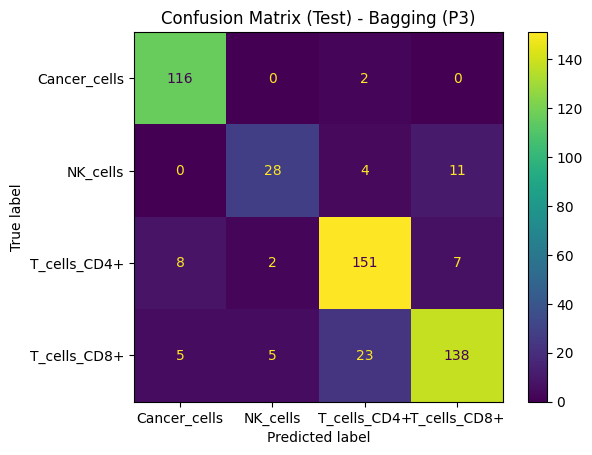

In [9]:
X_train_base = preprocess_log1p(preprocess_normalize_sum(X_train))
X_test_base  = preprocess_log1p(preprocess_normalize_sum(X_test))

top_k = 2000
gene_idx = fit_hvg_variance(X_train_base, top_k=top_k)

X_train_3 = transform_gene_filter(X_train_base, gene_idx).astype(np.float32)
X_test_3  = transform_gene_filter(X_test_base, gene_idx).astype(np.float32)

# -------------------------------------------------
# Base tree (use your tuned tree)
# -------------------------------------------------
base_tree = DecisionTreeClassifier(
    max_depth=8,
    min_samples_leaf=20,
    min_samples_split=2,
    class_weight="balanced",
    random_state=42
)

# -------------------------------------------------
# Bagging
# -------------------------------------------------
pipe_bag_p3 = Pipeline(
    [
        ("Bagging", BaggingClassifier(
            estimator=base_tree,
            n_estimators=200,
            max_samples=1.0,
            max_features=0.3,
            bootstrap=True,
            bootstrap_features=False,
            n_jobs=-1,
            random_state=42
        )),
    ]
)

pipe_bag_p3.fit(X_train_3, y_train)

y_train_pred = pipe_bag_p3.predict(X_train_3)
y_test_pred  = pipe_bag_p3.predict(X_test_3)

print("Bagging (P3) - Train balanced accuracy:", round(balanced_accuracy_score(y_train, y_train_pred), 4))
print("Bagging (P3) - Test  balanced accuracy:", round(balanced_accuracy_score(y_test, y_test_pred), 4))

cm = confusion_matrix(y_test, y_test_pred, labels=pipe_bag_p3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_bag_p3.classes_)
disp.plot()
plt.title("Confusion Matrix (Test) - Bagging (P3)")
plt.show()


In [7]:
n_estimators_list = [50, 100, 200, 400]
max_samples_list = [0.5, 0.7, 0.8, 1.0]
max_features_list = [0.3, 0.5, 0.7, 0.9]

best = None

for n in n_estimators_list:
    for ms in max_samples_list:
        for mf in max_features_list:
            bag = BaggingClassifier(
                estimator=base_tree,          # if error -> use base_estimator=base_tree
                n_estimators=n,
                max_samples=ms,
                max_features=mf,
                bootstrap=True,
                bootstrap_features=False,
                n_jobs=-1,
                random_state=42
            )

            bag.fit(X_train_3, y_train)
            y_pred = bag.predict(X_test_3)
            score = balanced_accuracy_score(y_test, y_pred)

            print(f"n={n}, max_samples={ms}, max_features={mf} -> test bal acc = {score:.4f}")

            if best is None or score > best["score"]:
                best = {"score": score, "n_estimators": n, "max_samples": ms, "max_features": mf}

print("\nBEST:")
print(best)

n=50, max_samples=0.5, max_features=0.3 -> test bal acc = 0.8131
n=50, max_samples=0.5, max_features=0.5 -> test bal acc = 0.7927
n=50, max_samples=0.5, max_features=0.7 -> test bal acc = 0.7720
n=50, max_samples=0.5, max_features=0.9 -> test bal acc = 0.7853
n=50, max_samples=0.7, max_features=0.3 -> test bal acc = 0.8262
n=50, max_samples=0.7, max_features=0.5 -> test bal acc = 0.7897
n=50, max_samples=0.7, max_features=0.7 -> test bal acc = 0.7904
n=50, max_samples=0.7, max_features=0.9 -> test bal acc = 0.7925
n=50, max_samples=0.8, max_features=0.3 -> test bal acc = 0.8247
n=50, max_samples=0.8, max_features=0.5 -> test bal acc = 0.7839
n=50, max_samples=0.8, max_features=0.7 -> test bal acc = 0.8020
n=50, max_samples=0.8, max_features=0.9 -> test bal acc = 0.8065
n=50, max_samples=1.0, max_features=0.3 -> test bal acc = 0.8290
n=50, max_samples=1.0, max_features=0.5 -> test bal acc = 0.7963
n=50, max_samples=1.0, max_features=0.7 -> test bal acc = 0.7904
n=50, max_samples=1.0, ma

### Voting Method

In [13]:

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)
sw = compute_sample_weight(class_weight="balanced", y=y_train_enc)

# --------------------------
# Base models
# --------------------------
base_tree = DecisionTreeClassifier(
    max_depth=8,
    min_samples_leaf=20,
    min_samples_split=2,
    class_weight="balanced",
    random_state=42
)

bag = BaggingClassifier(
    estimator=base_tree,
    n_estimators=200,
    max_samples=1.0,
    max_features=0.3,
    bootstrap=True,
    bootstrap_features=False,
    n_jobs=-1,
    random_state=42
)

hgb = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=3,
    max_leaf_nodes=31,
    min_samples_leaf=20,
    l2_regularization=1.0,
    early_stopping=True,
    random_state=42
)

lgbm = LGBMClassifier(
    objective="multiclass",
    num_class=len(le.classes_),
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.6,
    colsample_bytree=0.4,
    reg_lambda=5.0,
    reg_alpha=0.0,
    random_state=42,
    n_jobs=-1,
    force_col_wise=True,
    max_bin=127
)

# --------------------------
# Weight tuning (small grid)
# --------------------------
weight_grid = [
    (1, 1, 1),
    (1, 1, 2),
    (1, 2, 2),
    (1, 2, 3),
    (2, 1, 3),
    (2, 2, 3),
    (1, 1, 3),
    (2, 1, 2),
]

best = None

for w_bag, w_hgb, w_lgbm in weight_grid:
    vote = VotingClassifier(
        estimators=[("bag", bag), ("hgb", hgb), ("lgbm", lgbm)],
        voting="soft",
        weights=[w_bag, w_hgb, w_lgbm]
    )

    # sample_weight will be used by estimators that support it (LGBM does)
    vote.fit(X_train_3, y_train_enc, sample_weight=sw)

    y_pred = vote.predict(X_test_3)
    score = balanced_accuracy_score(y_test_enc, y_pred)

    print(f"weights(bag,hgb,lgbm)=({w_bag},{w_hgb},{w_lgbm}) -> test bal acc = {score:.4f}")

    if best is None or score > best["score"]:
        best = {"score": score, "weights": (w_bag, w_hgb, w_lgbm)}

print("\nBEST:", best)


[LightGBM] [Info] Total Bins 153193
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 1985
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g